In [58]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

from typing import Dict, Tuple, Any, List, Optional

from statsmodels.tsa.stattools import adfuller

# Add the scripts directory to the path
scripts_dir = Path("..") / "scripts"
sys.path.append(str(scripts_dir.resolve()))

from vis_trend import plot_total_publications,plot_top_categories,test_stationarity, visualize_stationarity,analyze_top_categories
from vis_trend import plot_category_growth_rates, plot_category_heatmap, plot_category_proportions, identify_trending_categories
from time_transform import transform_to_stationary, find_best_transformation,visualize_transformation,transform_multiple_categories
from forecasting import compare_forecast_models,forecast_future_periods,create_growth_rate_summary
from forecasting import train_test_split_time_series,fit_arima_model,inverse_transform, evaluate_forecast
from total_growth_dec import classify_category_trends, plot_category_trend

%reload_ext autoreload
%autoreload 2

# Overview

This is notebook two of three notebooks for this project. 

1. Model building and testing using sciBert
2. **Trend analysis**
3. Author network analysis

# Conclusions

Forecasting within specific categories was not successful. Interstingly, the transform to make the data stationary was different for different categories, suggesting some data attributes that may be specific to each category. Additionally, I removed data from 2025 as there was only a months worth of data here. Interestingly, retaining the 2025 data made the data seem stationary (unexpected) and removing revealed the data was not stationary (expected).

While forecasting within categoreis was not successful, identifying overall trends within the data was more successful. Interestingly, all categories were increasing to some degree, but I think this is consistent wiht the overall increase in the number of papers published in general.

# Using the Arxiv dataset to look at publication trends

Activities:
- [X] Load data and ensure it is stationary- if not make it stationary
- [X] Plot the number of papers published over time
- [X] Attempt Forecasting within categories 
- [X] Topic Modeling 
- [X] Generate a list of the top 10 topics in the data set.
- [X] Generate a list of the top 10 topics in the data set over time.

In [4]:
df = pd.read_parquet('../data/processed/arxiv_scientific_dataset_final.parquet')
display(df)

id                                              title  \
0           cs-9308101v1                               Dynamic Backtracking   
1           cs-9308102v1  A Market-Oriented Programming Environment and ...   
2           cs-9309101v1            An Empirical Analysis of Search in GSAT   
3           cs-9311101v1  The Difficulties of Learning Logic Programs wi...   
4           cs-9311102v1  Software Agents: Completing Patterns and Const...   
...                  ...                                                ...   
112516  abs-2501.18184v1         Genetic Algorithm with Border Trades (GAB)   
112517  abs-2501.18280v1  Jailbreaking LLMs' Safeguard with Universal Ma...   
108722  abs-2405.20132v4  LLaMEA: A Large Language Model Evolutionary Al...   
112519  abs-2501.18504v1  CLEAR: Cue Learning using Evolution for Accura...   
136132  abs-2407.13101v2  Retrieve, Summarize, Plan: Advancing Multi-hop...   

                                                 category category_code  \
0                                 Artificial Intelligence         cs.AI   
1                                 Artificial Intelligence         cs.AI   
2                                 Artificial Intelligence         cs.AI   
3                                 Artificial Intelligence         cs.AI   
4                                 Artificial Intelligence         cs.AI   
...                                                   ...           ...   
112516                                   Machine Learning         cs.LG   
112517  Computation and Language (Natural Language Pro...         cs.CL   
108722                  Neural and Evolutionary Computing         cs.NE   
112519            Computer Vision and Pattern Recognition         cs.CV   
136132  Computation and Language (Natural Language Pro...         cs.CL   

       published_date updated_date  \
0          1993-08-01   1993-08-01   
1          1993-08-01   1993-08-01   
2          1993-09-01   1993-09-01   
3          1993-11-01   1993-11-01   
4          1993-11-01   1993-11-01   
...               ...          ...   
112516     2025-01-30   2025-01-30   
112517     2025-01-30   2025-01-30   
108722     2024-05-30   2025-01-30   
112519     2025-01-30   2025-01-30   
136132     2024-07-18   2025-01-30   

                                                  authors        first_author  \
0                                      ['M. L. Ginsberg']    'M. L. Ginsberg'   
1                                       ['M. P. Wellman']     'M. P. Wellman'   
2                              ['I. P. Gent', 'T. Walsh']        'I. P. Gent'   
3          ['F. Bergadano', 'D. Gunetti', 'U. Trinchero']      'F. Bergadano'   
4                    ['J. C. Schlimmer', 'L. A. Hermens']   'J. C. Schlimmer'   
...                                                   ...                 ...   
112516                                  ['Qingchuan Lyu']     'Qingchuan Lyu'   
112517  ['Haoyu Liang', 'Youran Sun', 'Yunfeng Cai', '...       'Haoyu Liang'   
108722                  ['Niki van Stein', 'Thomas Bäck']    'Niki van Stein'   
112519  ['Peter J. Bentley', 'Soo Ling Lim', 'Fuyuki I...  'Peter J. Bentley'   
136132  ['Zhouyu Jiang', 'Mengshu Sun', 'Lei Liang', '...      'Zhouyu Jiang'   

                                                  summary  summary_word_count  \
0       Because of their occasional need to return to ...                  79   
1       Market price systems constitute a well-underst...                 119   
2       We describe an extensive study of search in GS...                 167   
3       As real logic programmers normally use cut (!)...                 174   
4       To support the goal of allowing users to recor...                 187   
...                                                   ...                 ...   
112516  This paper introduces a novel approach to impr...                  74   
112517  The security issue of large language models (L...                 150   
108722  Large

In [5]:
print(df.dtypes)

id                             object
title                          object
category                       object
category_code                  object
published_date         datetime64[ns]
updated_date           datetime64[ns]
authors                        object
first_author                   object
summary                        object
summary_word_count              int64
author_count                    int64
title_count                     int64
author_count_boxcox           float64
title_count_sqrt              float64
published_year                  int32
published_quarter       period[Q-DEC]
published_month             period[M]
updated_year                    int32
updated_quarter         period[Q-DEC]
updated_month               period[M]
year_period                  category
dtype: object


In [6]:
print(df['category'].value_counts())

category
Machine Learning                                          39967
Computer Vision and Pattern Recognition                   29050
Computation and Language (Natural Language Processing)    25198
Artificial Intelligence                                   12943
Machine Learning (Statistics)                             10432
                                                          ...  
History and Philosophy of Physics                             1
General Mathematics                                           1
Number Theory                                                 1
Pattern Formation and Solitons                                1
Complex Variables                                             1
Name: count, Length: 138, dtype: int64


# Visualize data and determine if it is stationary

## Initial data analysis

In [7]:
# Print basic information about the data
print(f"Data range: {df['published_date'].min()} to {df['published_date'].max()}")
print(f"Total publications: {len(df)}")

Data range: 1993-08-01 00:00:00 to 2025-01-30 00:00:00
Total publications: 136160


In [8]:
# The data only has 1 month of data for 2025. Will drop 2025 data
filtered_df = df[df['published_date'] < '2025-01-01']
print(f"Total rows: {len(df)}")
print(f"Rows after removing 2025 data: {len(filtered_df)}")
print(f"Total rows removed: {len(df) - len(filtered_df)}")

Total rows: 136160
Rows after removing 2025 data: 135635
Total rows removed: 525


In [9]:
print(f"Data range: {filtered_df['published_date'].min()} to {filtered_df['published_date'].max()}")

Data range: 1993-08-01 00:00:00 to 2024-12-31 00:00:00


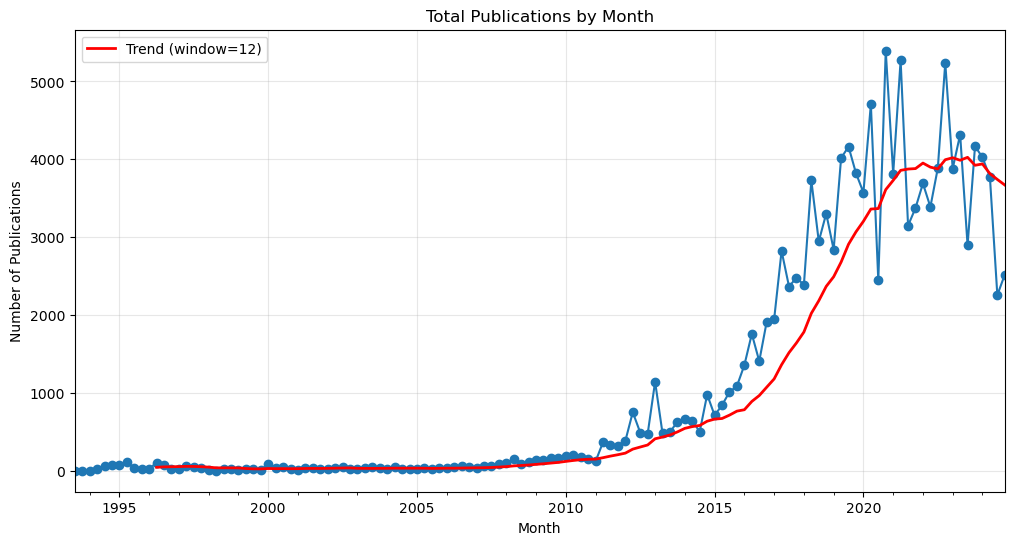

In [10]:
#Plot total publications over time (quarterly)
fig_total_q = plot_total_publications(filtered_df, freq='QE')
plt.show()

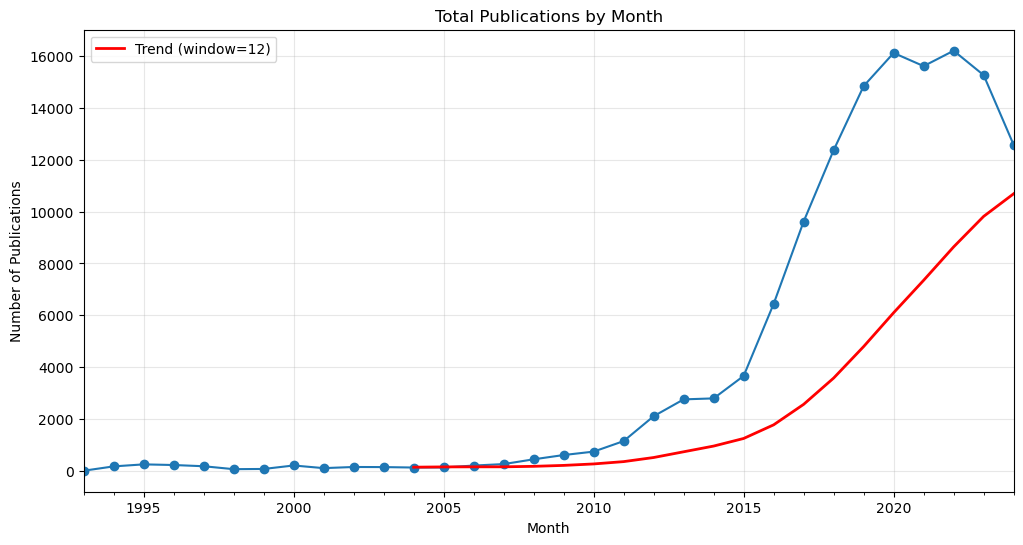

In [11]:
# Also plot yearly for a broader view
fig_total_y = plot_total_publications(filtered_df, freq='YE')

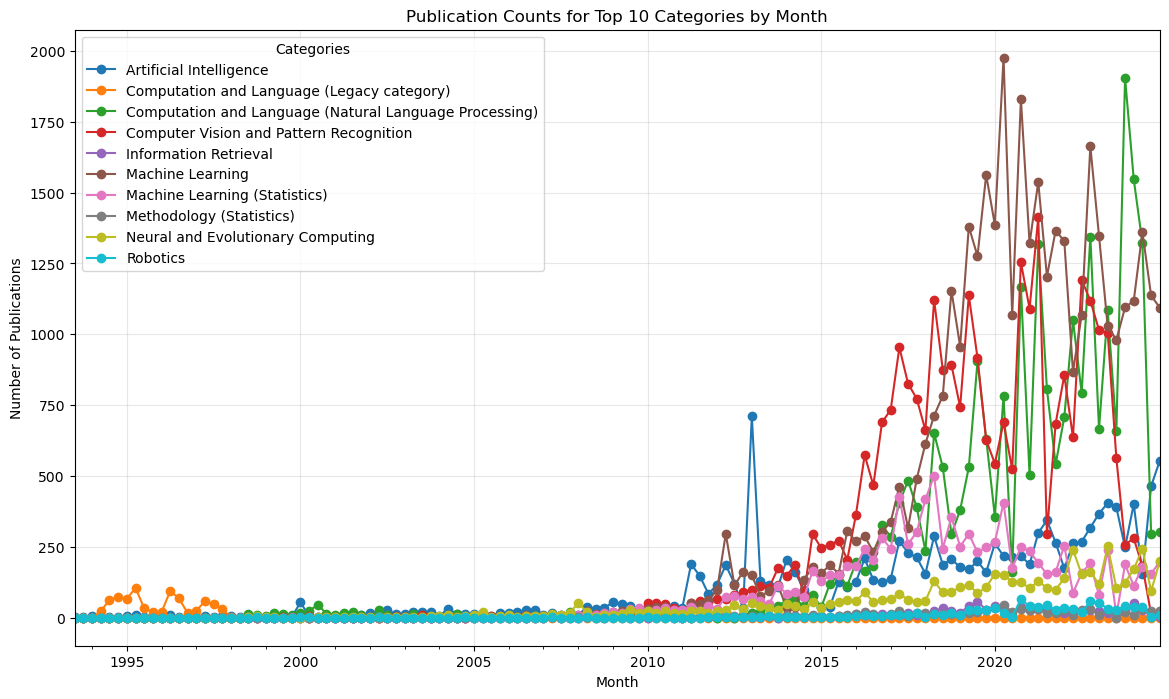

In [12]:
# Plot top categories over time
fig_categories_q = plot_top_categories(filtered_df, top_n=10, freq='QE')

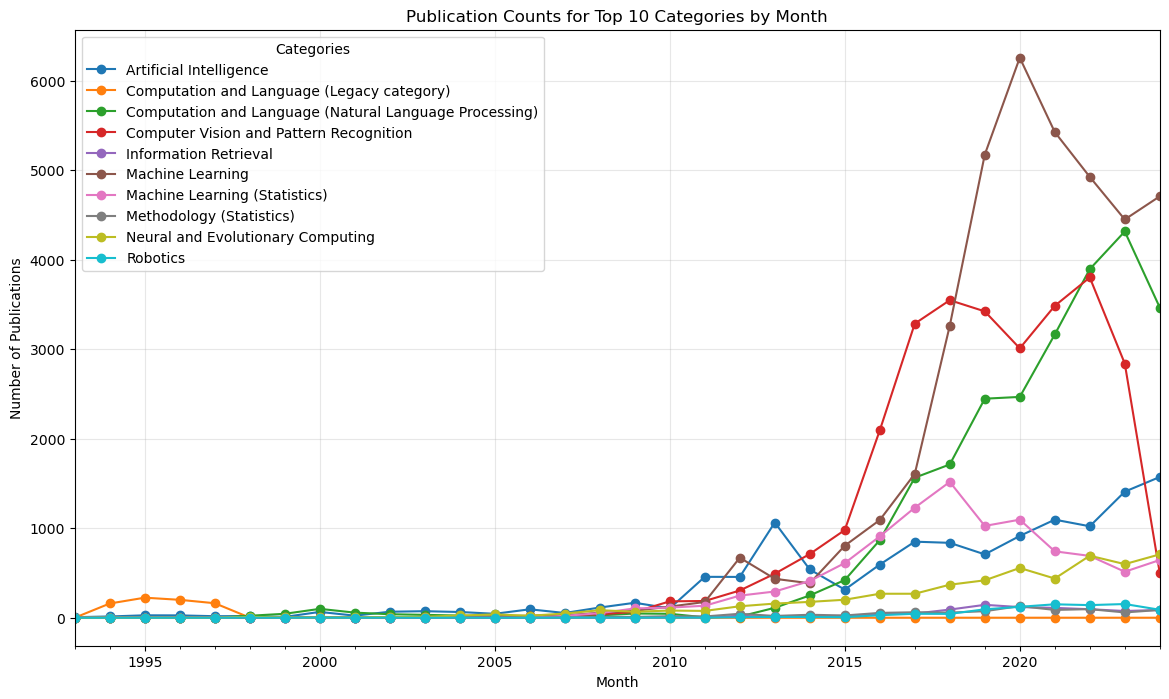

In [13]:
# Plot top categories over time- and by year
fig_categories_q = plot_top_categories(filtered_df, top_n=10, freq='YE')

ADF Statistic: -2.3666
p-value: 0.1514
Critical Values:
   1%: -3.4875
   5%: -2.8866
   10%: -2.5801
Is Stationary: False


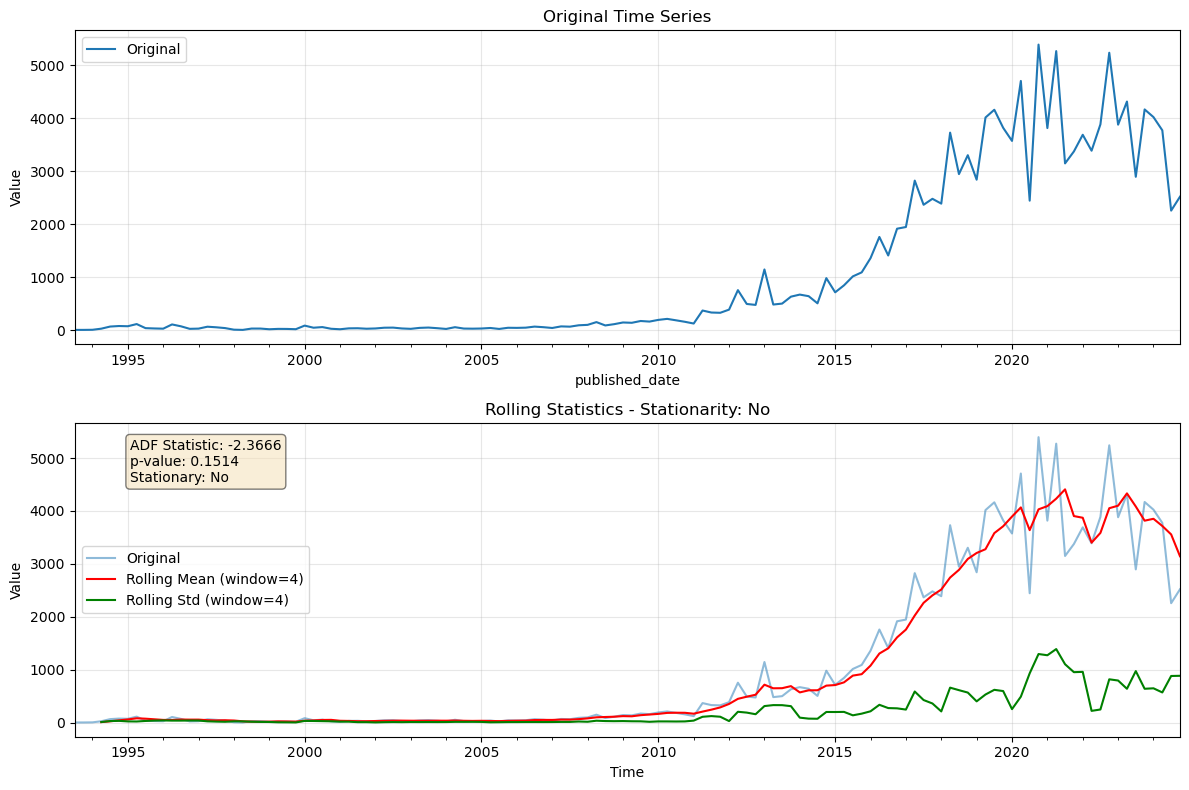

In [14]:
#Test and visualize stationarity for quarterly data for the entire dataset
# Get quarterly publication counts
quarterly_counts = filtered_df.groupby(pd.Grouper(key='published_date', freq='QE')).size()
quarterly_test_results = test_stationarity(quarterly_counts)
# Visualize stationarity
fig_stationarity = visualize_stationarity(quarterly_counts, window=4)
plt.show()

# Note
When I ran this with the full dataset, the data were determined to be stationary. The limited data for 2025 probably helped create that artifact. 

# The total dataset is not-stationary

Will now explore category data.

In [15]:
# Analyze top categories
category_counts, stationarity_results = analyze_top_categories(filtered_df, top_n=10, freq='QE')

Analyzing top 10 categories:
1. Machine Learning (39735 publications)
2. Computer Vision and Pattern Recognition (29043 publications)
3. Computation and Language (Natural Language Processing) (25196 publications)
4. Artificial Intelligence (12819 publications)
5. Machine Learning (Statistics) (10355 publications)
6. Neural and Evolutionary Computing (5456 publications)
7. Robotics (902 publications)
8. Information Retrieval (901 publications)
9. Methodology (Statistics) (880 publications)
10. Computation and Language (Legacy category) (746 publications)


In [16]:
# Print stationarity results
print("\nStationarity Test Results for Top Categories:")
for category, results in stationarity_results.items():
    status = results.get('Is Stationary', None)
    if status is None:
        print(f"{category}: Could not determine (insufficient data)")
    else:
        p_value = results.get('p-value', None)
        print(f"{category}: {'Stationary' if status else 'Non-stationary'} (p-value: {p_value:.4f})")


Stationarity Test Results for Top Categories:
Machine Learning: Non-stationary (p-value: 0.9335)
Computer Vision and Pattern Recognition: Non-stationary (p-value: 0.3611)
Computation and Language (Natural Language Processing): Non-stationary (p-value: 0.9847)
Artificial Intelligence: Non-stationary (p-value: 0.9932)
Machine Learning (Statistics): Non-stationary (p-value: 0.6096)
Neural and Evolutionary Computing: Non-stationary (p-value: 1.0000)
Robotics: Stationary (p-value: 0.0415)
Information Retrieval: Non-stationary (p-value: 0.7550)
Methodology (Statistics): Non-stationary (p-value: 0.9614)
Computation and Language (Legacy category): Stationary (p-value: 0.0000)


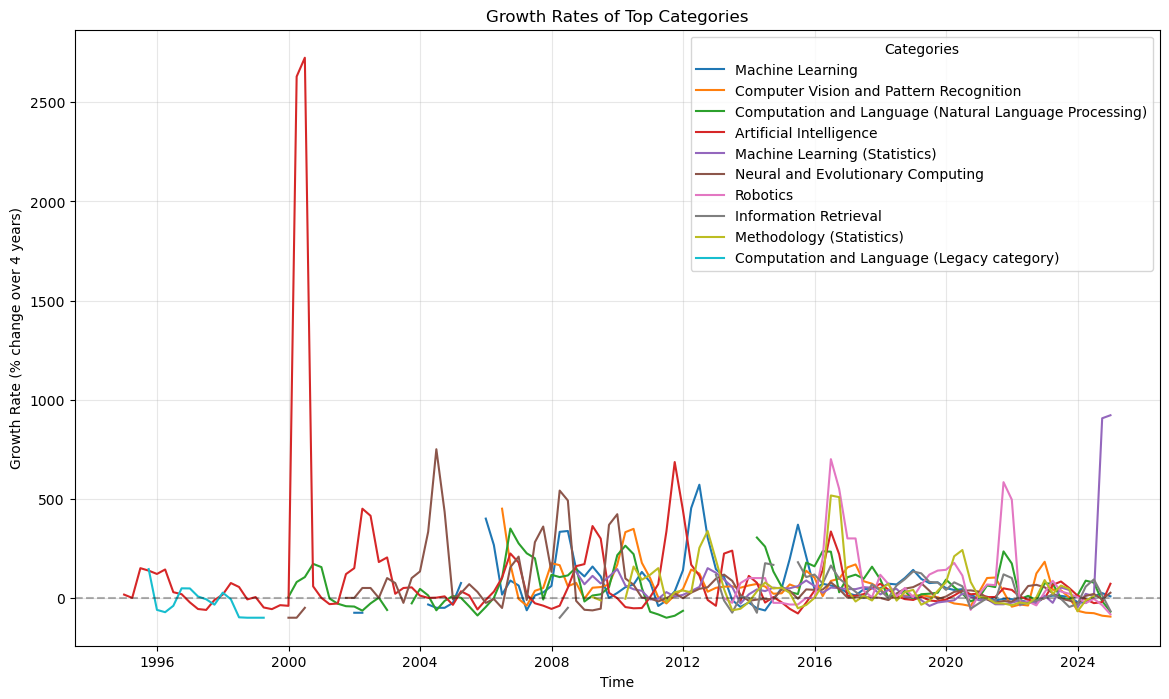

In [17]:
# Plot category growth rates
fig_growth = plot_category_growth_rates(category_counts, window=4)
plt.show()

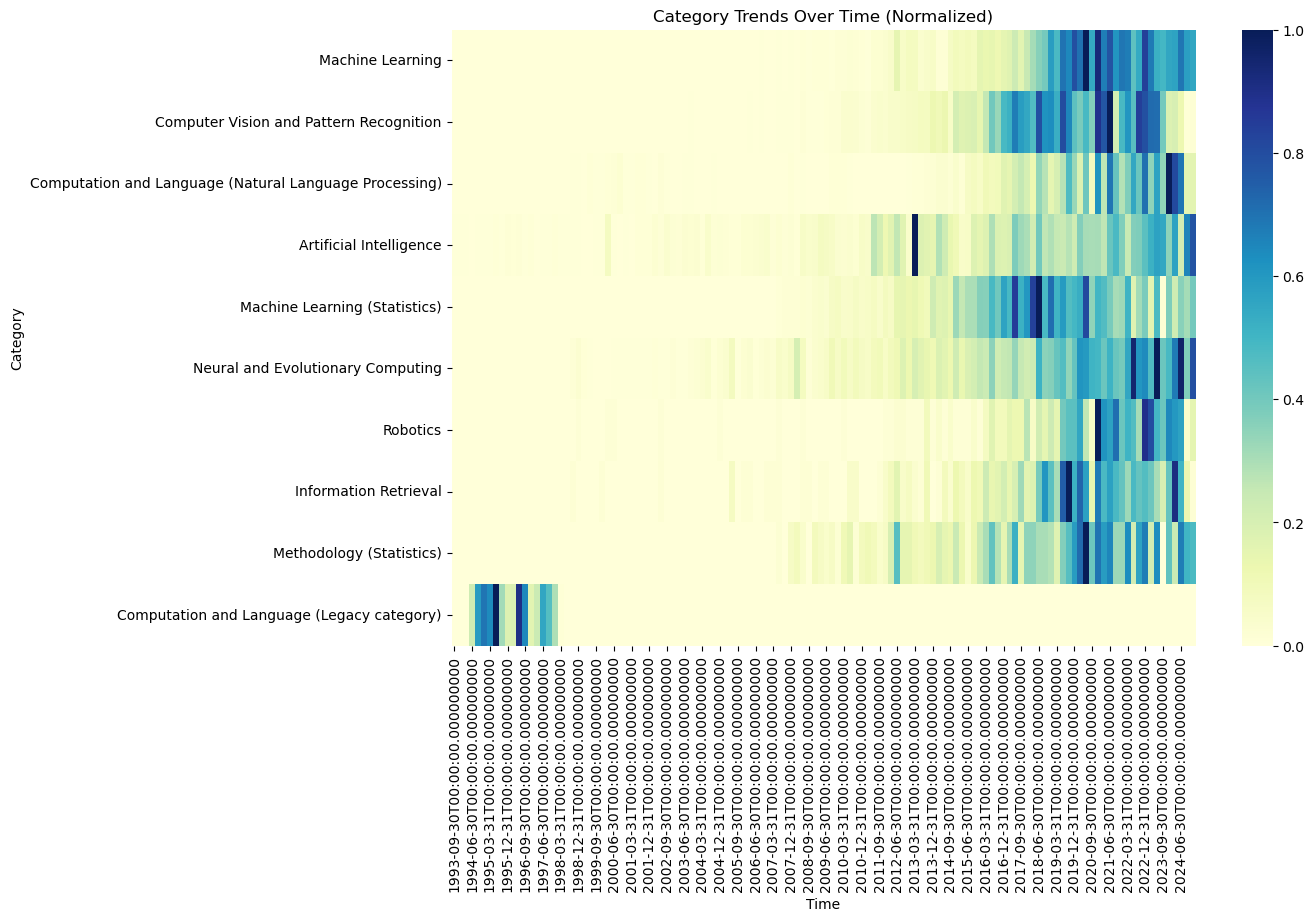

In [18]:
# Create a heatmap of category trends
fig_heatmap = plot_category_heatmap(category_counts)
plt.show()

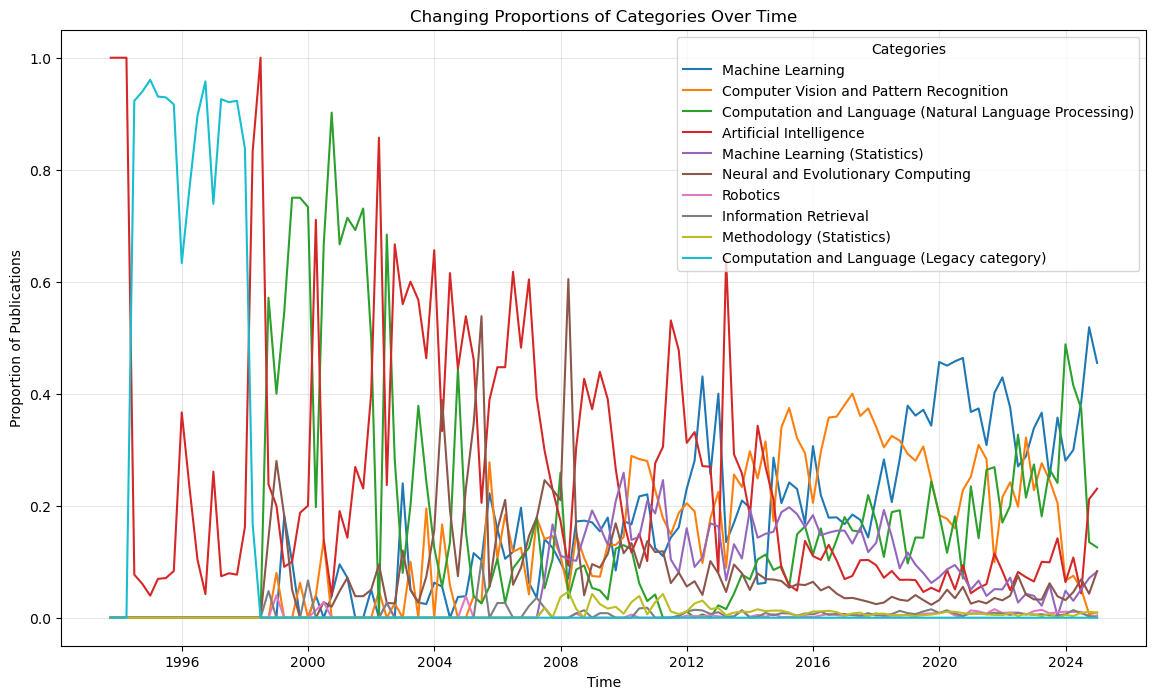

In [19]:
# Plot changing proportions of categories
fig_proportions = plot_category_proportions(category_counts)
plt.show()

In [20]:
# Identify trending categories
trending_categories = identify_trending_categories(filtered_df, num_periods=4, min_threshold=10)
display(trending_categories)

Category  Growth Rate (%)  \
9                            Methodology (Statistics)        47.457627   
8                       Machine Learning (Statistics)        25.486381   
10                  Neural and Evolutionary Computing        18.196995   
6                               Information Retrieval        16.000000   
0                             Artificial Intelligence        11.639461   
4                           Cryptography and Security         6.250000   
7                                    Machine Learning         5.818917   
1   Computation and Language (Natural Language Pro...       -19.689599   
12                               Software Engineering       -24.137931   
3                               Computers and Society       -39.215686   
5                          Human-Computer Interaction       -40.384615   
11                                           Robotics       -41.830065   
2             Computer Vision and Pattern Recognition       -82.470961   

    Recent Avg  Previous Avg      Trend  
9        21.75         14.75    Growing  
8       161.25        128.50    Growing  
10      177.00        149.75    Growing  
6        21.75         18.75    Growing  
0       393.25        352.25    Growing  
4        17.00         16.00    Growing  
7      1177.50       1112.75    Growing  
1       866.75       1079.25  Declining  
12       16.50         21.75  Declining  
3        15.50         25.50  Declining  
5        15.50         26.00  Declining  
11       22.25         38.25  Declining  
2       124.50        710.25  Declining

# Forecasting


In [21]:
# Get top categories
top_n = 13  # Use the 13 categories you identified
top_categories = filtered_df['category'].value_counts().nlargest(top_n).index.tolist()


Finding best transformation for: Machine Learning
  difference: p-value = 0.011427, Stationary: True
  log: p-value = 0.131615, Stationary: False
  log_difference: p-value = 0.000000, Stationary: True
  seasonal_difference: p-value = 0.166092, Stationary: False
  twice_difference: p-value = 0.006742, Stationary: True
  Best method: log_difference (p-value: 0.000000)

Finding best transformation for: Computer Vision and Pattern Recognition
  difference: p-value = 0.000000, Stationary: True
  log: p-value = 0.467413, Stationary: False
  log_difference: p-value = 0.000000, Stationary: True
  seasonal_difference: p-value = 0.729164, Stationary: False
  twice_difference: p-value = 0.000000, Stationary: True
  Best method: log_difference (p-value: 0.000000)

Finding best transformation for: Computation and Language (Natural Language Processing)
  difference: p-value = 0.914012, Stationary: False
  log: p-value = 0.774990, Stationary: False
  log_difference: p-value = 0.000000, Stationary: T

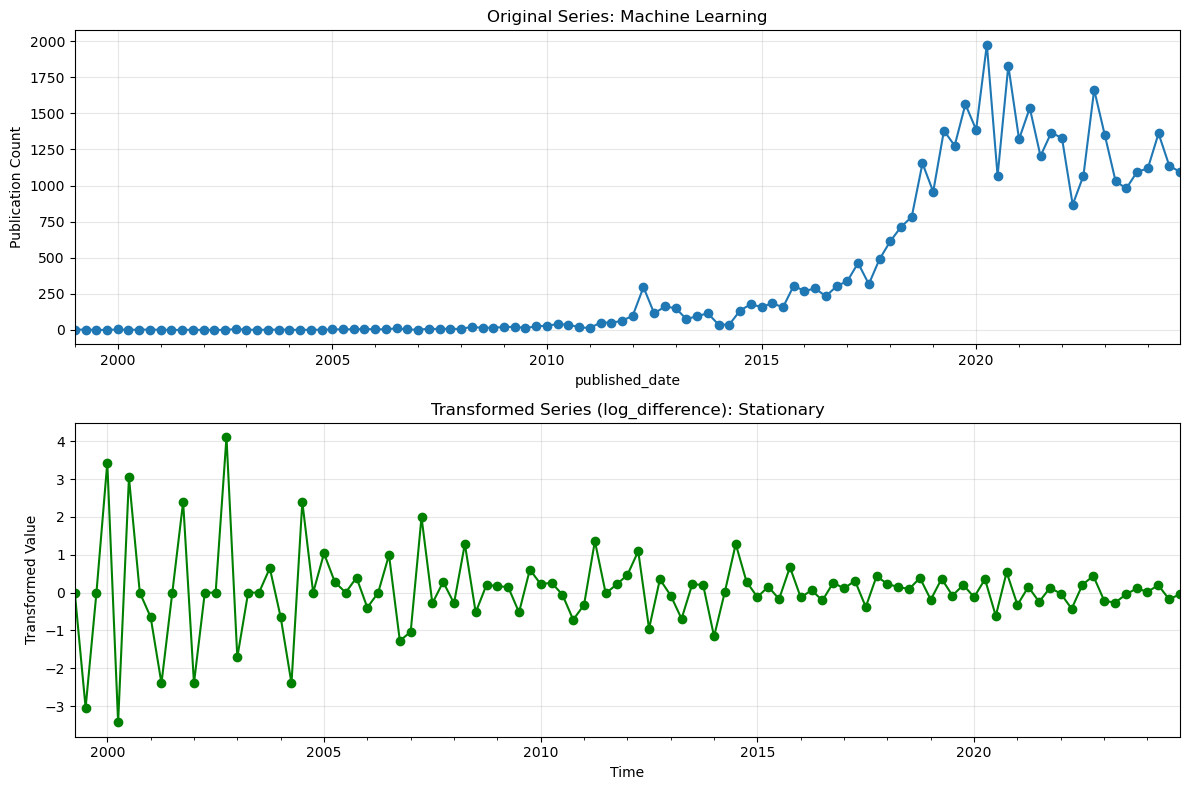

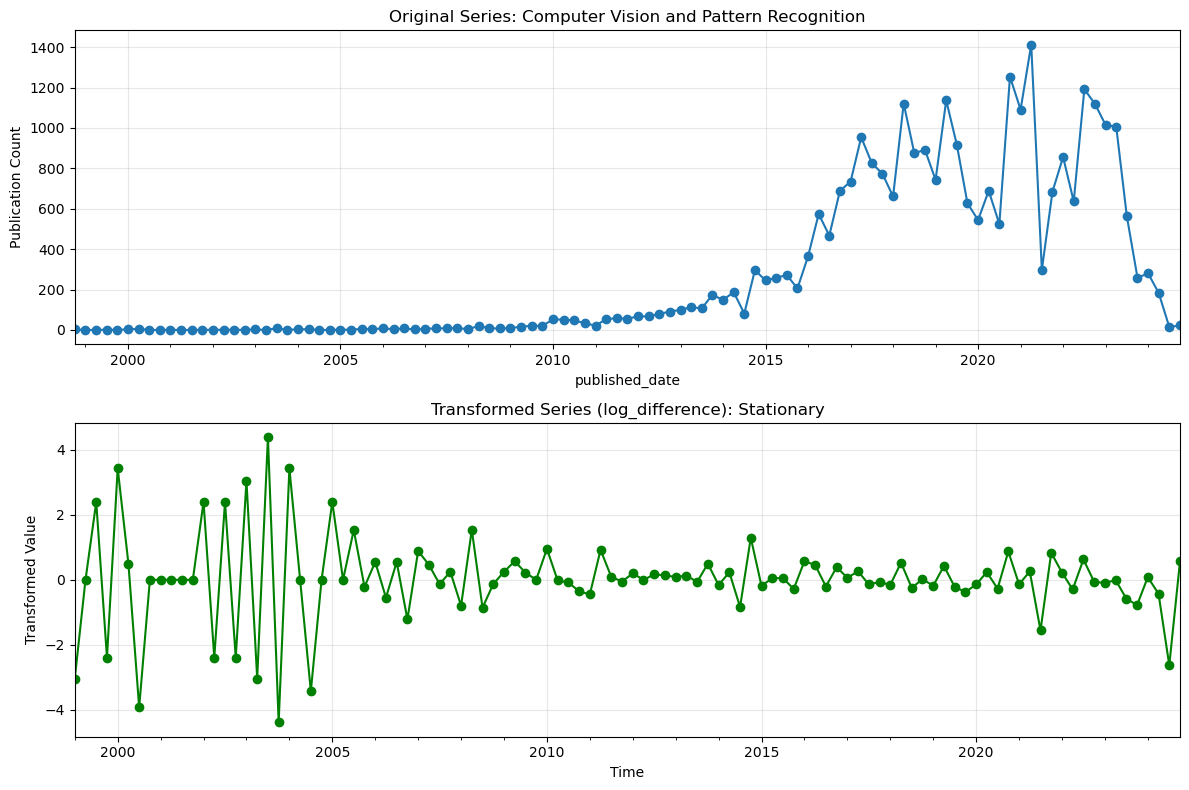

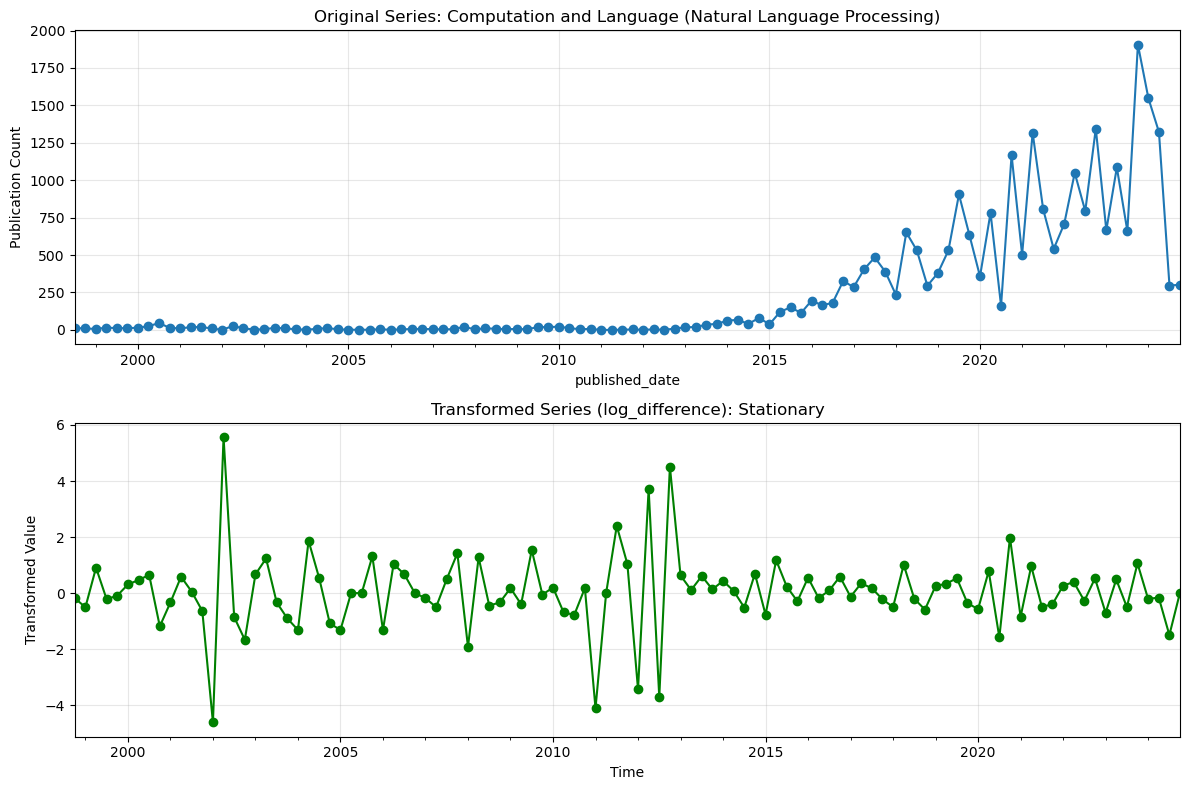

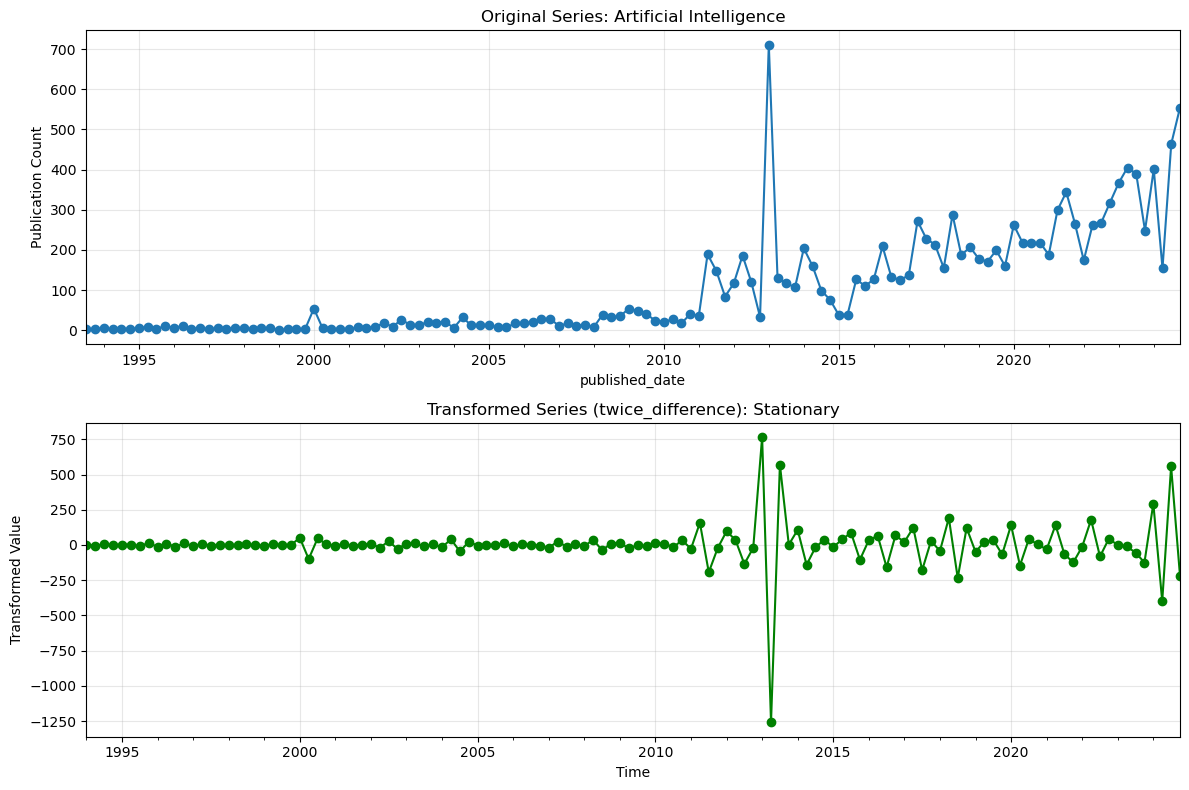

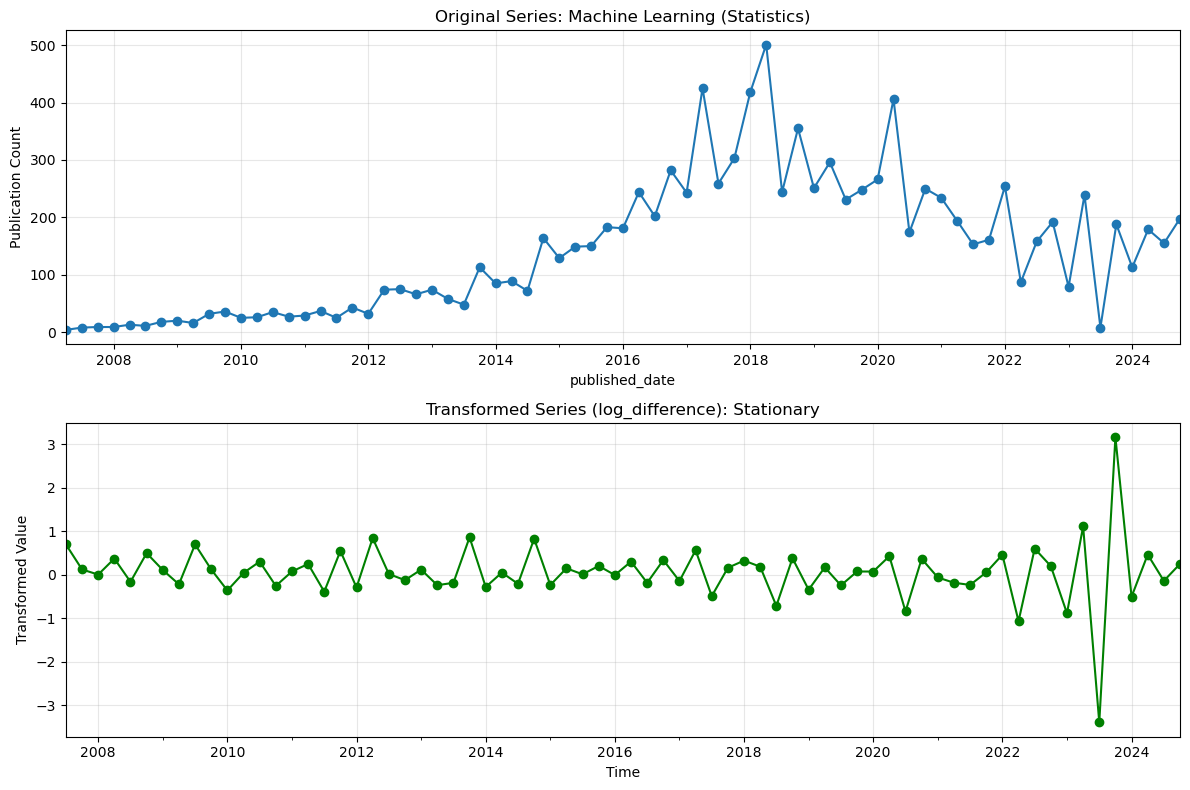

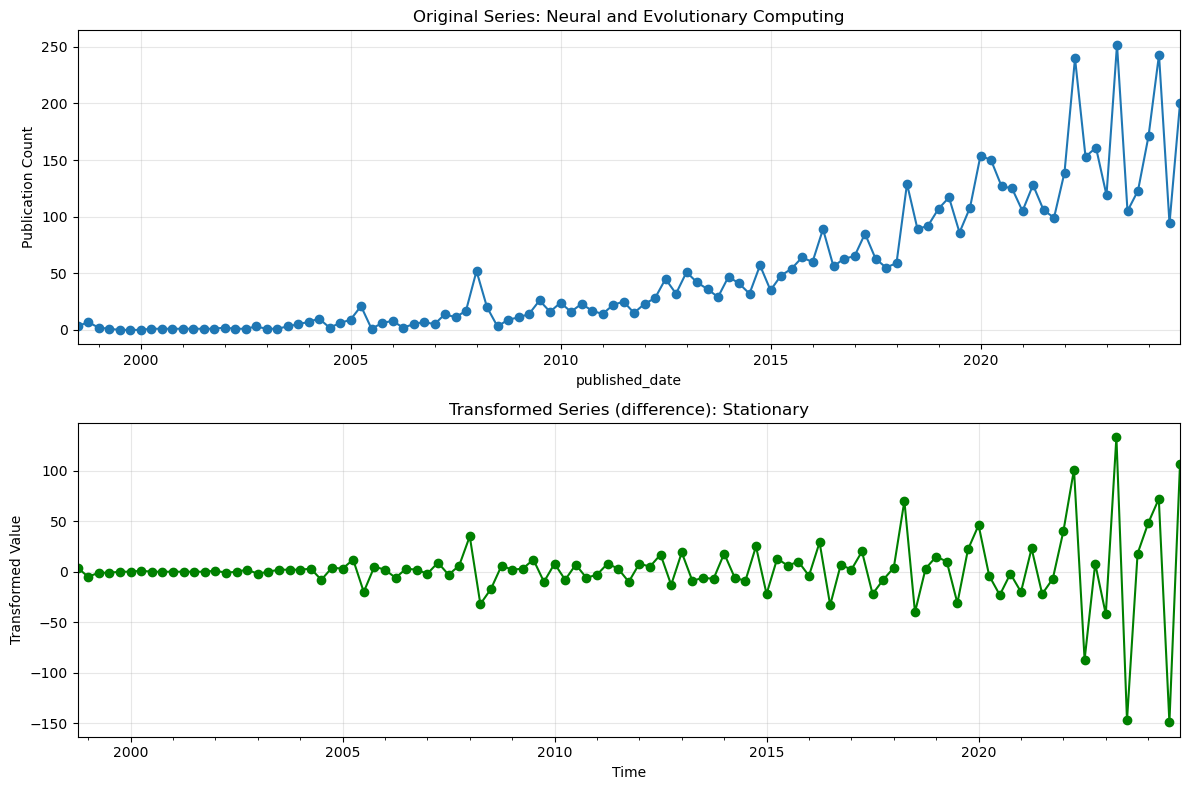

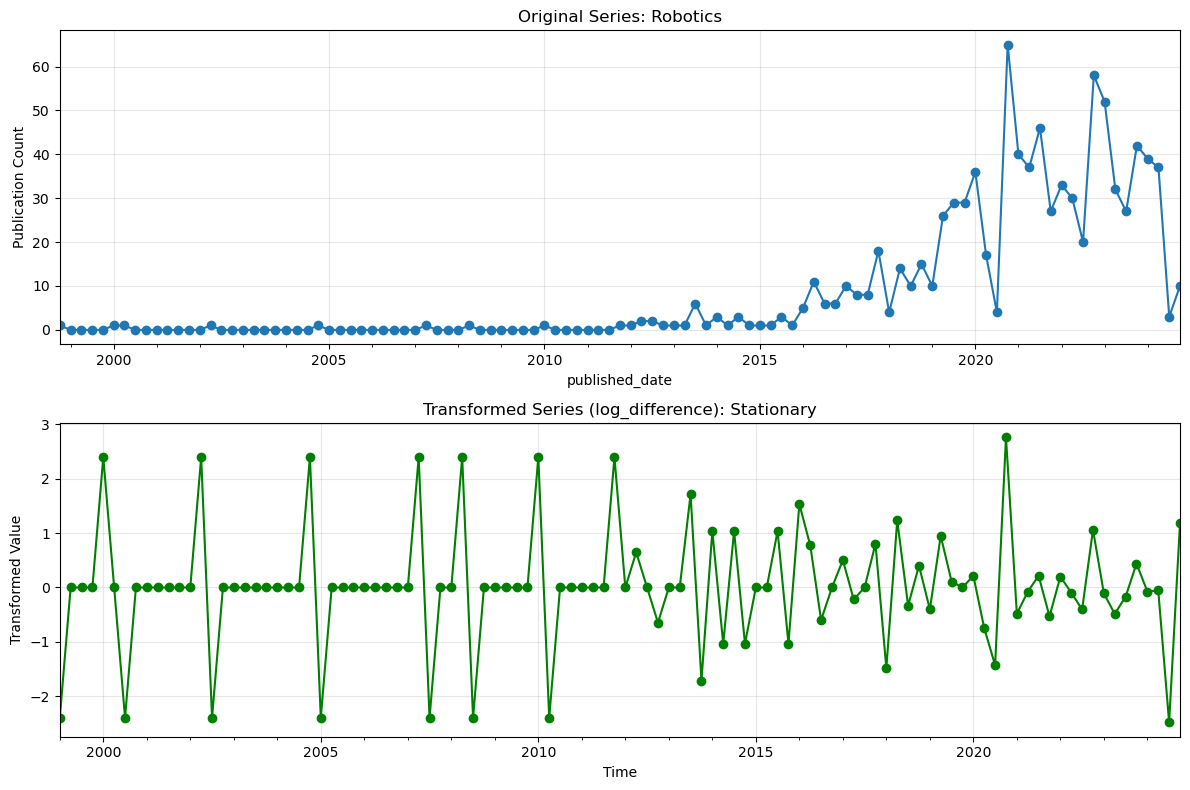

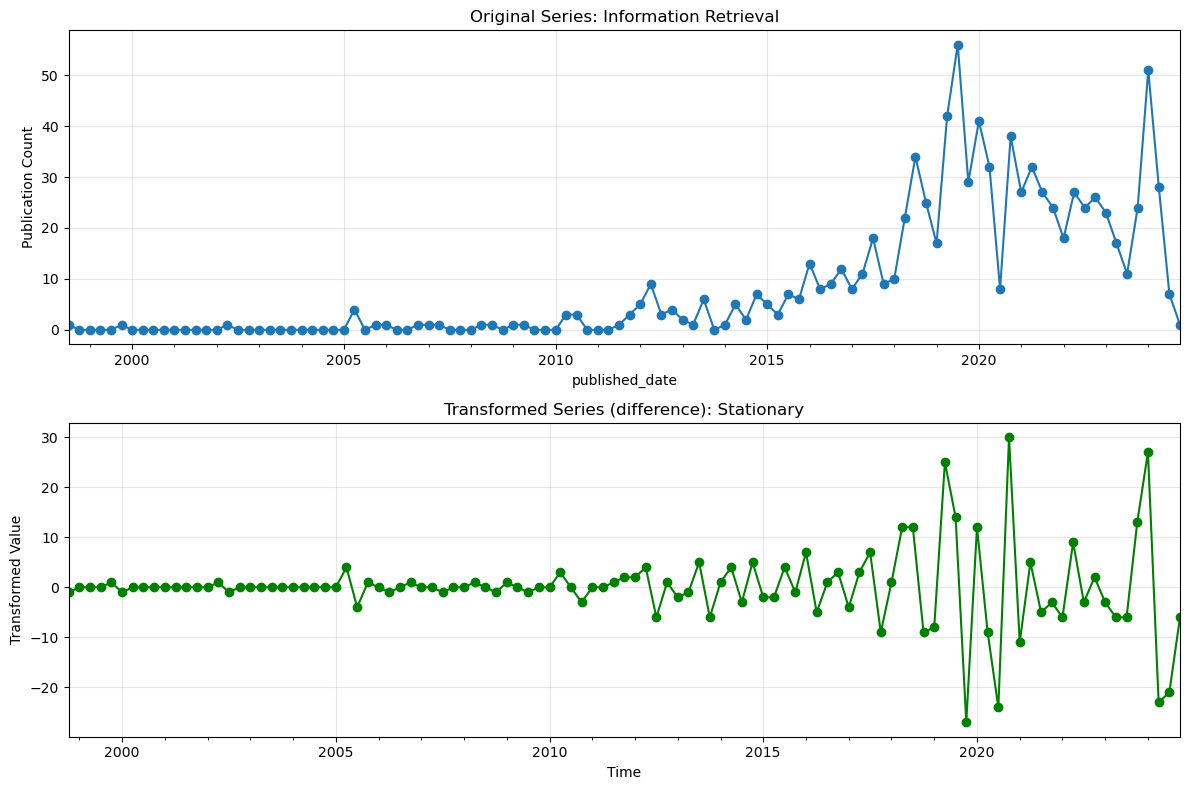

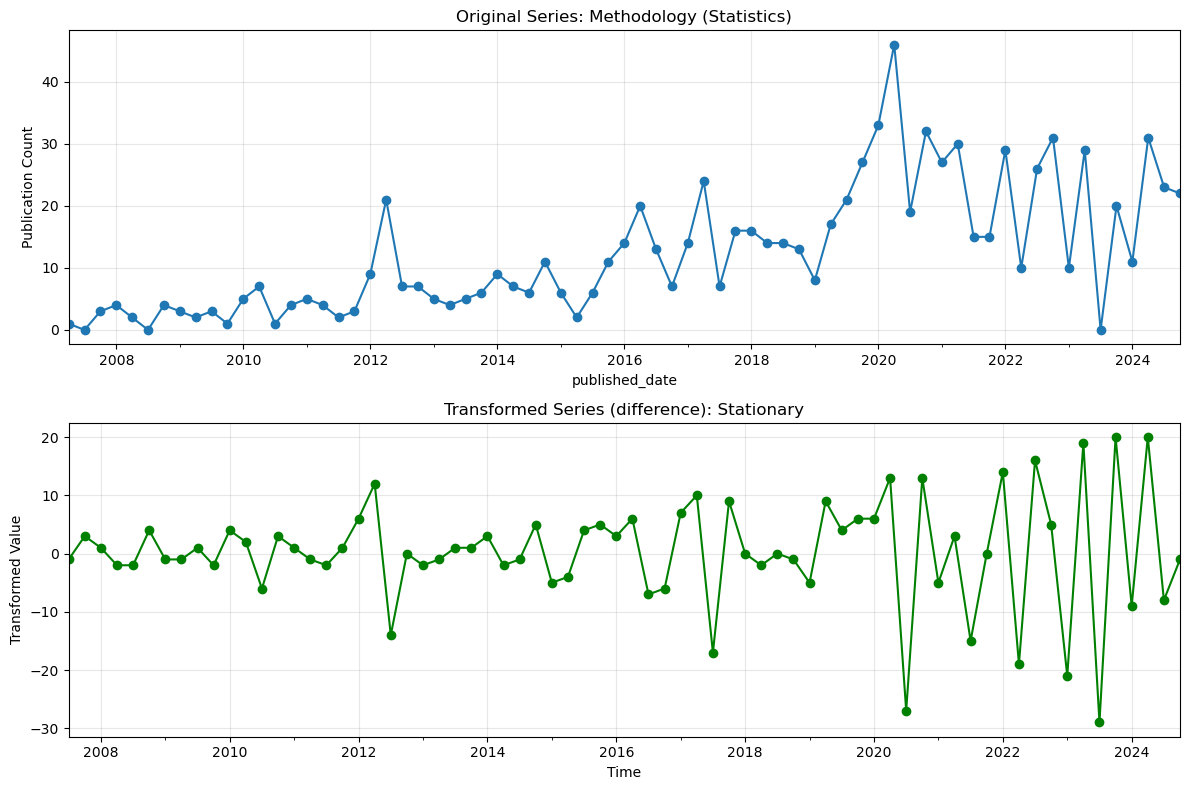

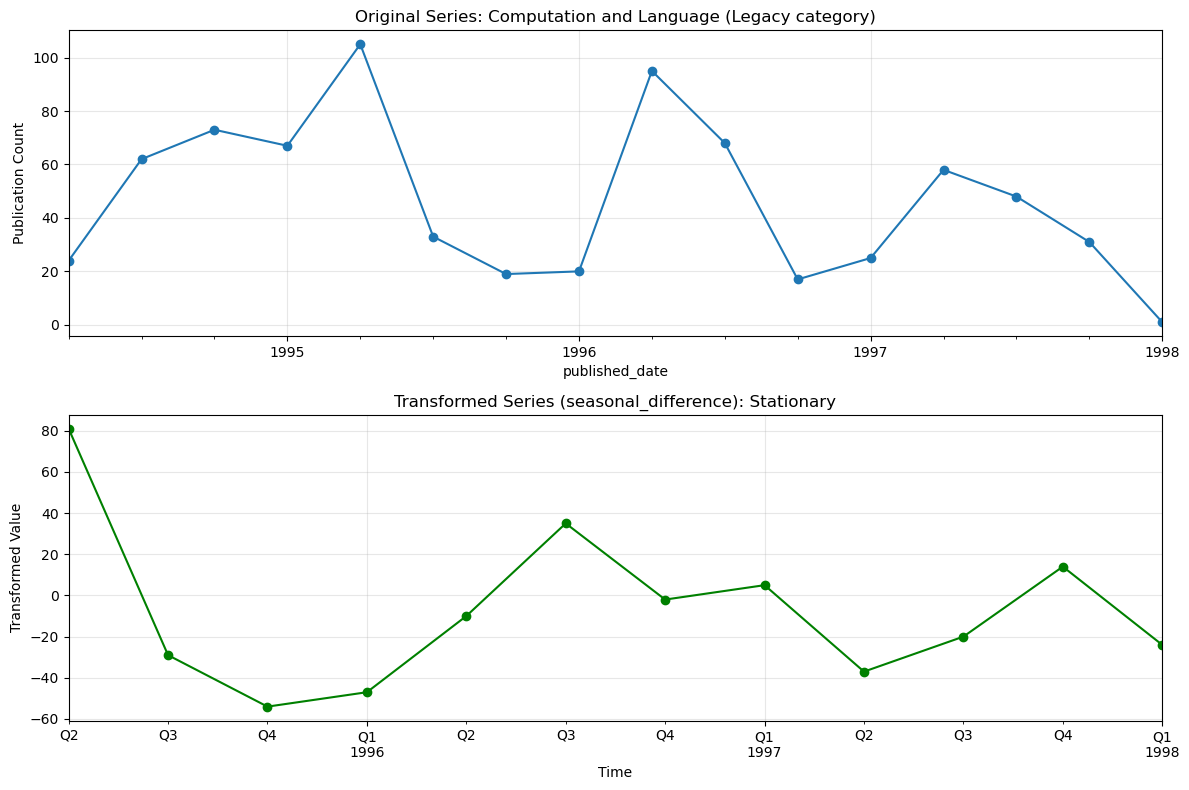

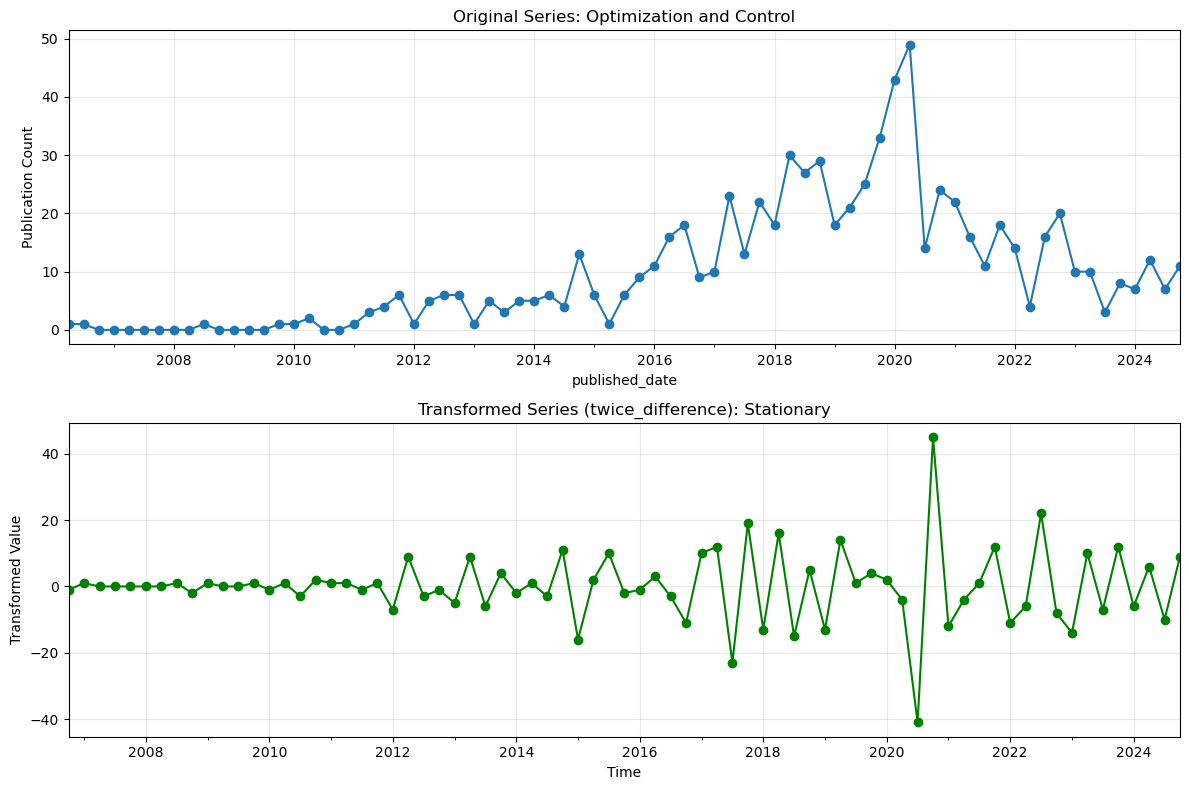

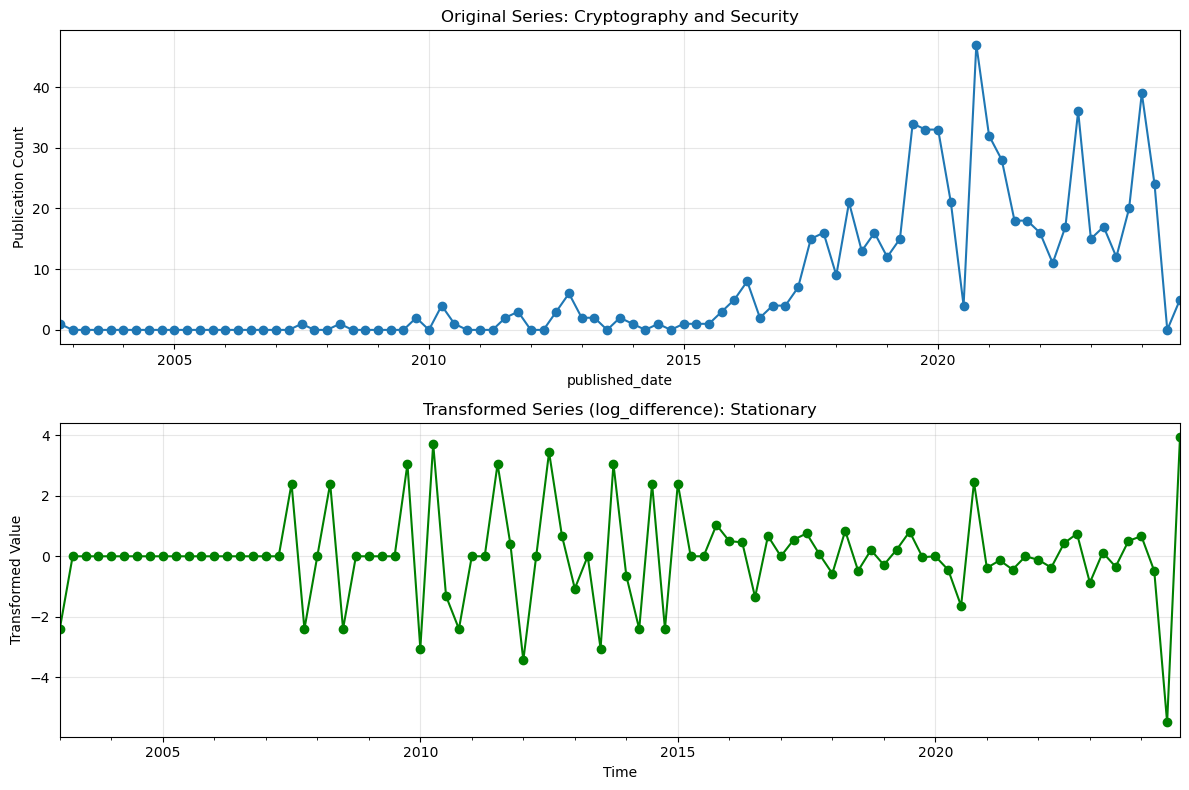

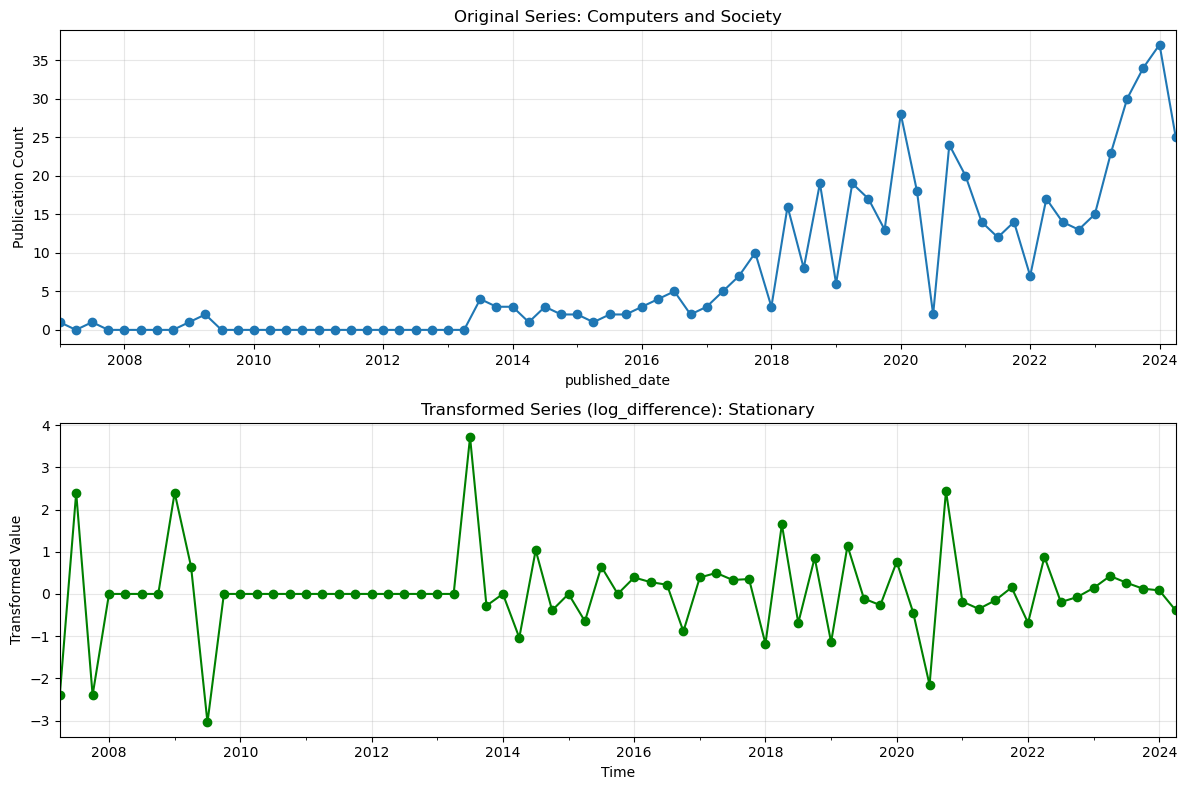

In [25]:
# Transform categories to make them stationary
transformation_results = transform_multiple_categories(filtered_df, top_categories, freq='QE')

In [26]:
# Print summary of results
print("\nTransformation Summary:")
for category, result in transformation_results['results'].items():
    status = "Stationary" if result['is_stationary'] else "Non-stationary"
    print(f"{category}: {result['best_method']} - {status} (p-value: {result['best_p_value']:.6f})")


Transformation Summary:
Machine Learning: log_difference - Stationary (p-value: 0.000000)
Computer Vision and Pattern Recognition: log_difference - Stationary (p-value: 0.000000)
Computation and Language (Natural Language Processing): log_difference - Stationary (p-value: 0.000000)
Artificial Intelligence: twice_difference - Stationary (p-value: 0.000000)
Machine Learning (Statistics): log_difference - Stationary (p-value: 0.000000)
Neural and Evolutionary Computing: difference - Stationary (p-value: 0.000000)
Robotics: log_difference - Stationary (p-value: 0.000000)
Information Retrieval: difference - Stationary (p-value: 0.000000)
Methodology (Statistics): difference - Stationary (p-value: 0.000000)
Computation and Language (Legacy category): seasonal_difference - Stationary (p-value: 0.000000)
Optimization and Control: twice_difference - Stationary (p-value: 0.014380)
Cryptography and Security: log_difference - Stationary (p-value: 0.000000)
Computers and Society: log_difference - 

# Transform data and compare models


===== Processing Category: Machine Learning =====

Comparing forecast models for: Machine Learning
Transformation method: log_difference
Training set size: 82
Test set size: 21
ARIMA - RMSE: 1326.94, MAPE: 99.60%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Machine Learning: ARIMA
RMSE: 1326.94, MAPE: 99.60%

Generating future forecast for Machine Learning using ARIMA...


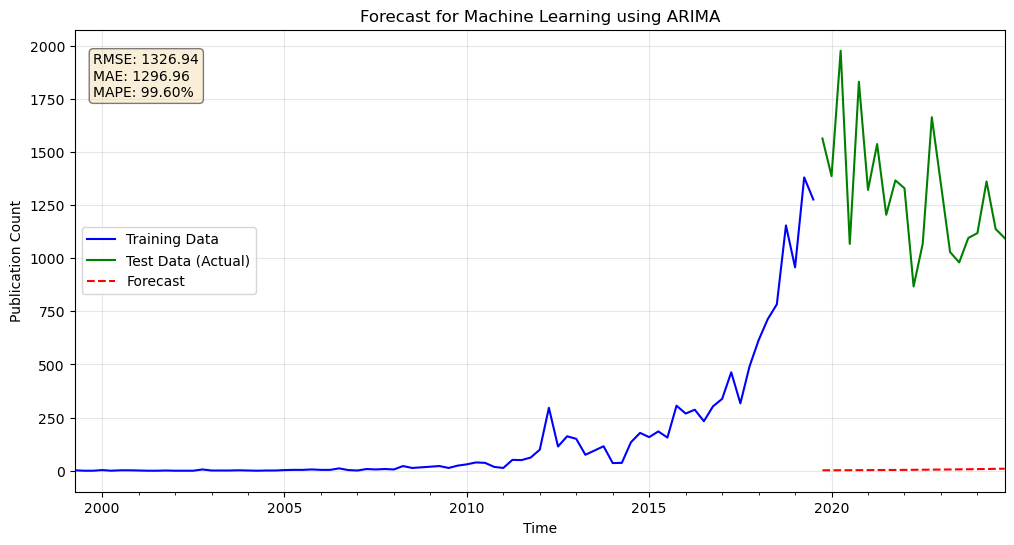

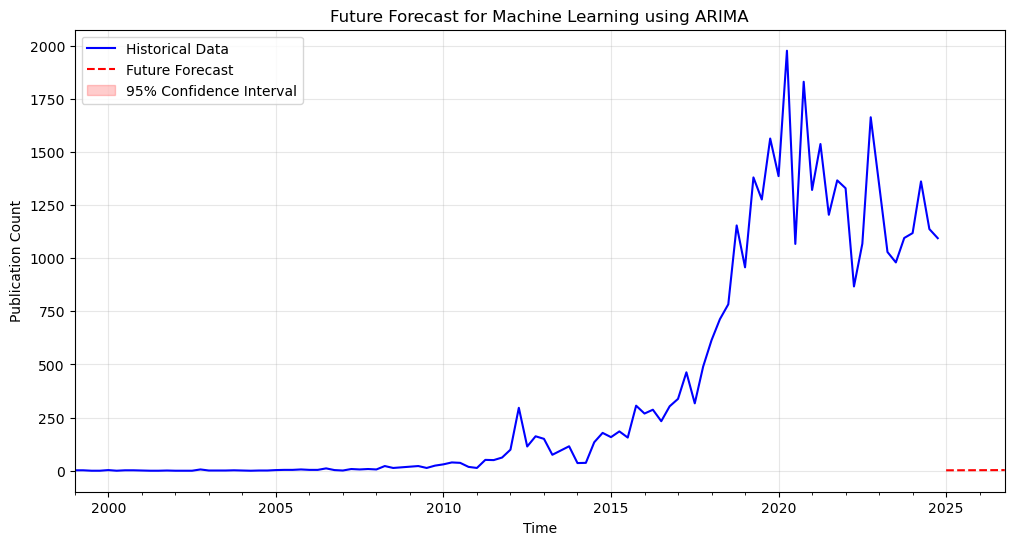


===== Processing Category: Computer Vision and Pattern Recognition =====

Comparing forecast models for: Computer Vision and Pattern Recognition
Transformation method: log_difference
Training set size: 83
Test set size: 21
ARIMA - RMSE: 786.21, MAPE: 93.07%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Computer Vision and Pattern Recognition: ARIMA
RMSE: 786.21, MAPE: 93.07%

Generating future forecast for Computer Vision and Pattern Recognition using ARIMA...


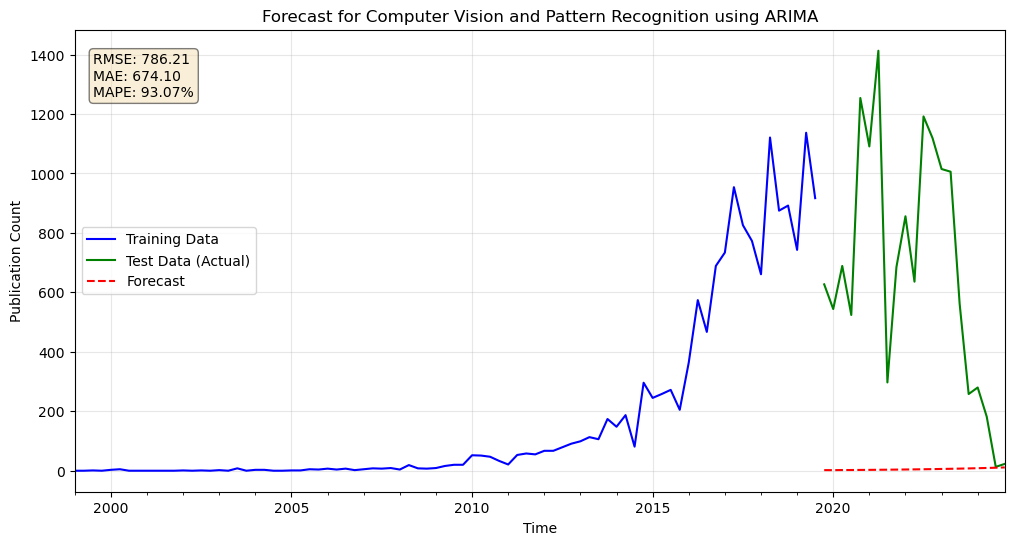

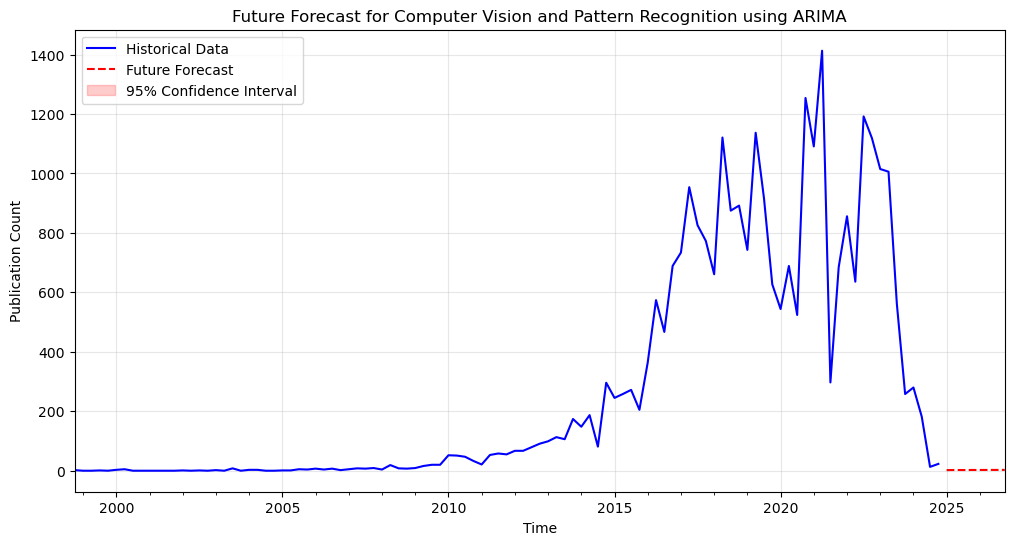


===== Processing Category: Computation and Language (Natural Language Processing) =====

Comparing forecast models for: Computation and Language (Natural Language Processing)
Transformation method: log_difference
Training set size: 84
Test set size: 21
ARIMA - RMSE: 943.49, MAPE: 96.33%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Computation and Language (Natural Language Processing): ARIMA
RMSE: 943.49, MAPE: 96.33%

Generating future forecast for Computation and Language (Natural Language Processing) using ARIMA...


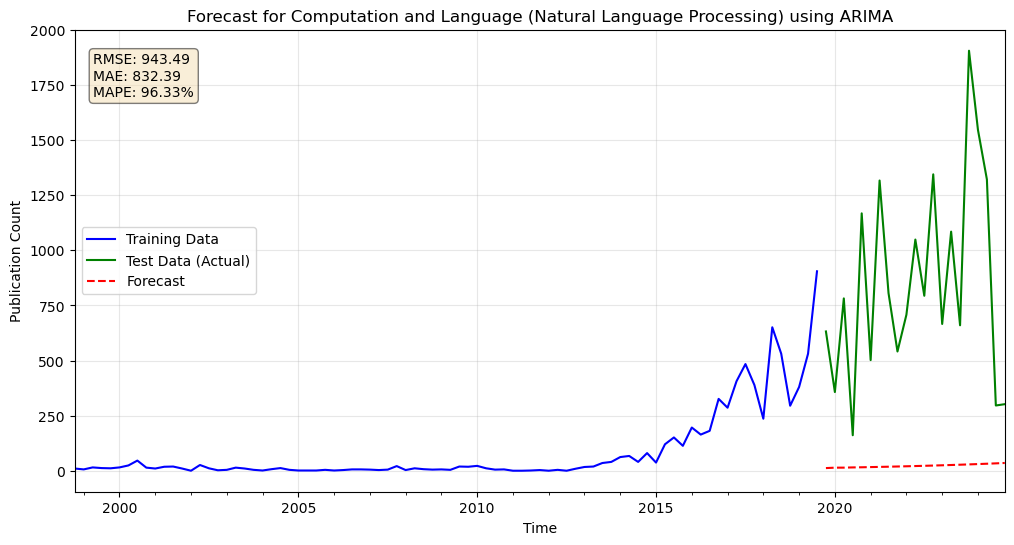

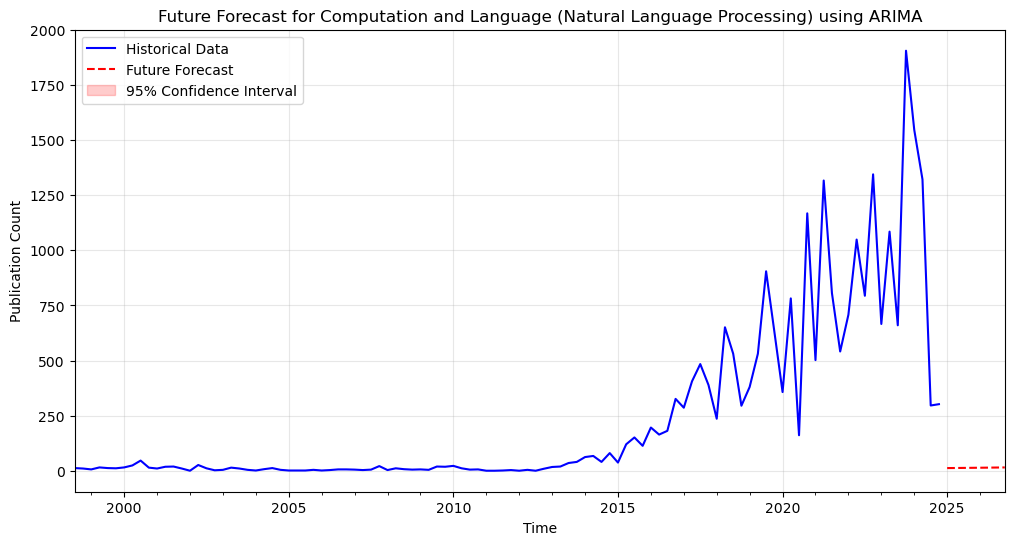


===== Processing Category: Artificial Intelligence =====

Comparing forecast models for: Artificial Intelligence
Transformation method: twice_difference
Training set size: 99
Test set size: 25
ARIMA - RMSE: 1175.82, MAPE: 377.12%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Artificial Intelligence: ARIMA
RMSE: 1175.82, MAPE: 377.12%

Generating future forecast for Artificial Intelligence using ARIMA...


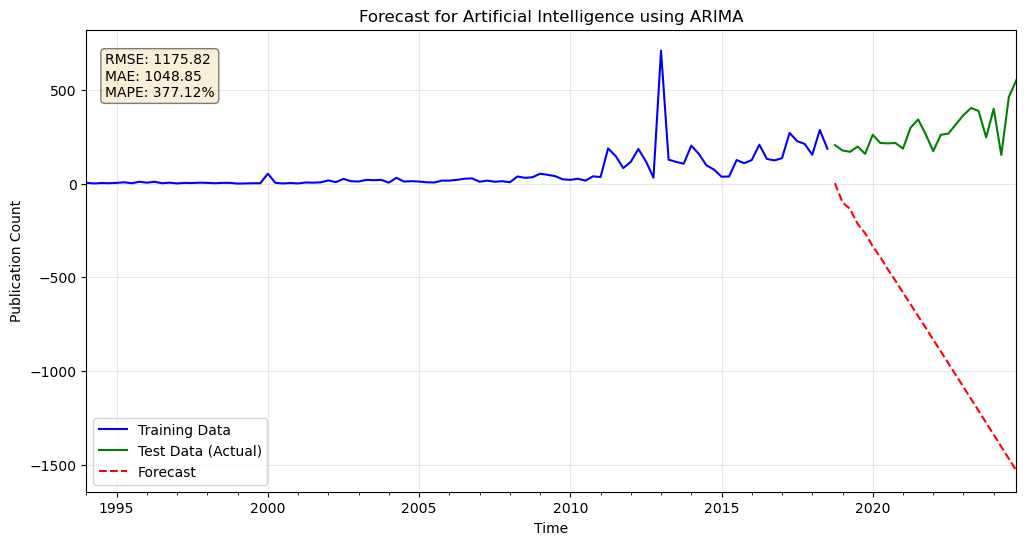

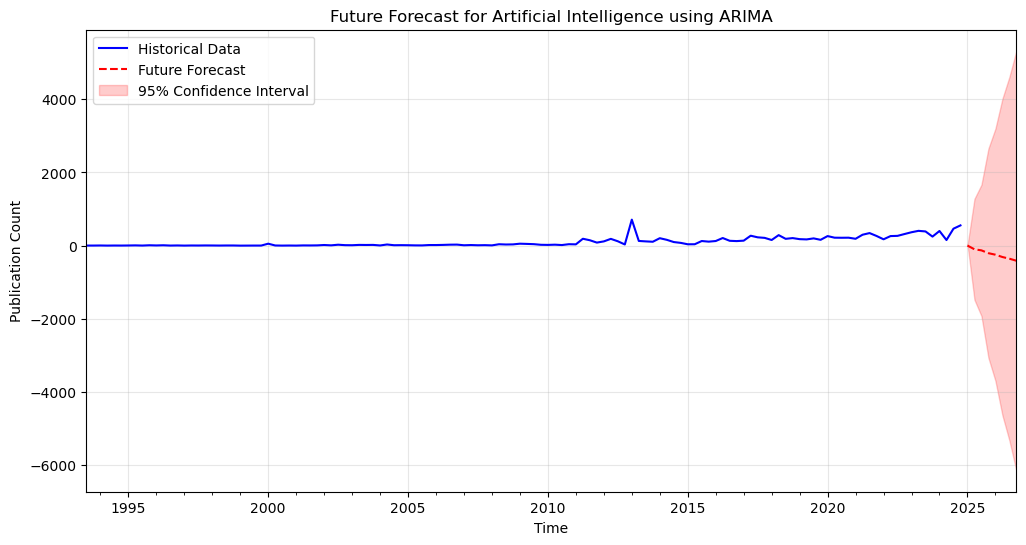


===== Processing Category: Machine Learning (Statistics) =====

Comparing forecast models for: Machine Learning (Statistics)
Transformation method: log_difference
Training set size: 56
Test set size: 14
ARIMA - RMSE: 161.26, MAPE: 90.40%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Machine Learning (Statistics): ARIMA
RMSE: 161.26, MAPE: 90.40%

Generating future forecast for Machine Learning (Statistics) using ARIMA...


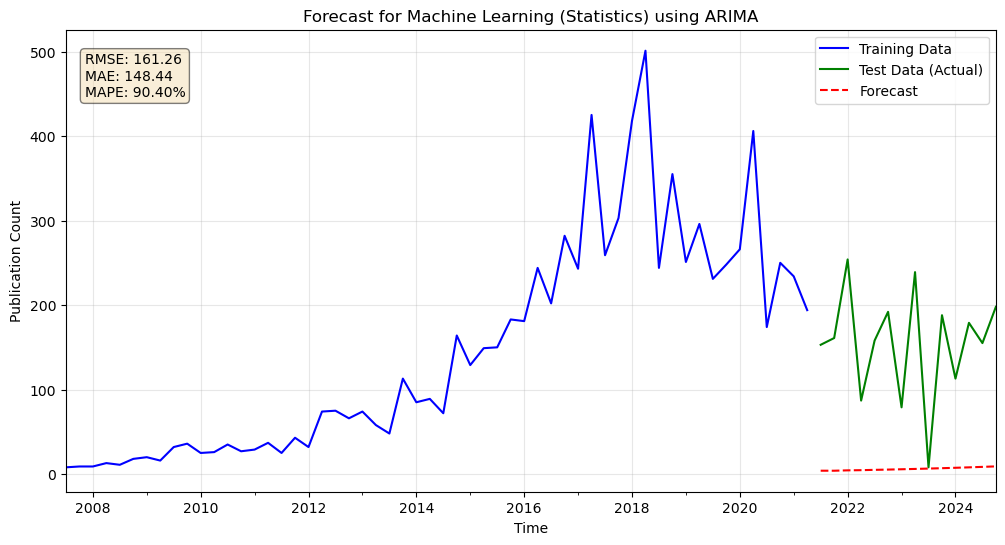

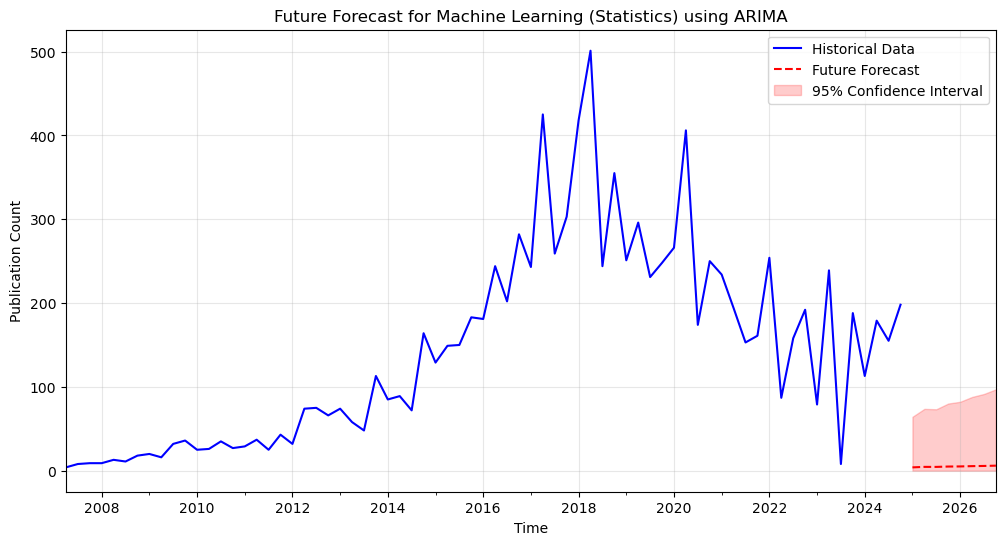


===== Processing Category: Neural and Evolutionary Computing =====

Comparing forecast models for: Neural and Evolutionary Computing
Transformation method: difference
Training set size: 84
Test set size: 21
ARIMA - RMSE: 145.15, MAPE: 92.98%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Neural and Evolutionary Computing: ARIMA
RMSE: 145.15, MAPE: 92.98%

Generating future forecast for Neural and Evolutionary Computing using ARIMA...


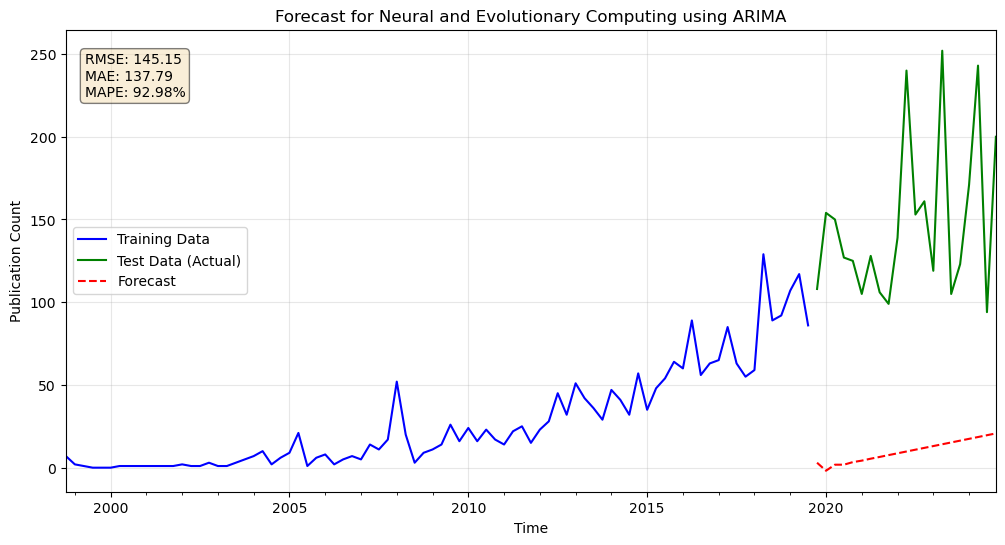

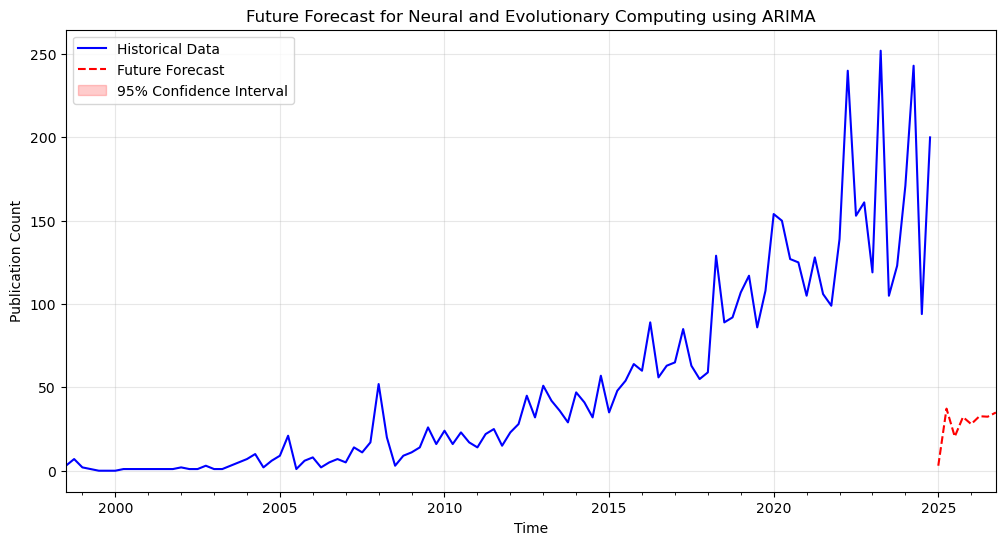


===== Processing Category: Robotics =====

Comparing forecast models for: Robotics
Transformation method: log_difference
Training set size: 83
Test set size: 21
ARIMA - RMSE: 34.67, MAPE: 89.21%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Robotics: ARIMA
RMSE: 34.67, MAPE: 89.21%

Generating future forecast for Robotics using ARIMA...


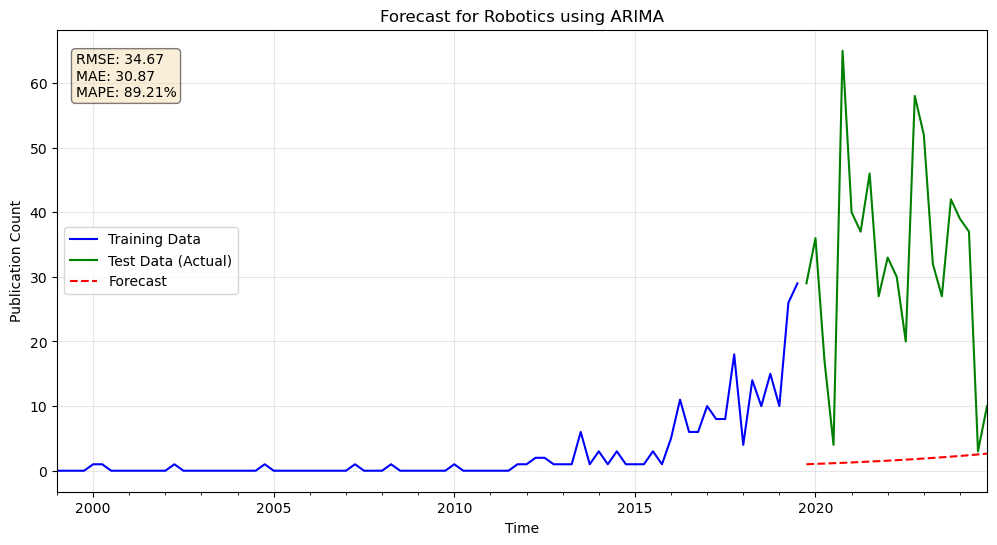

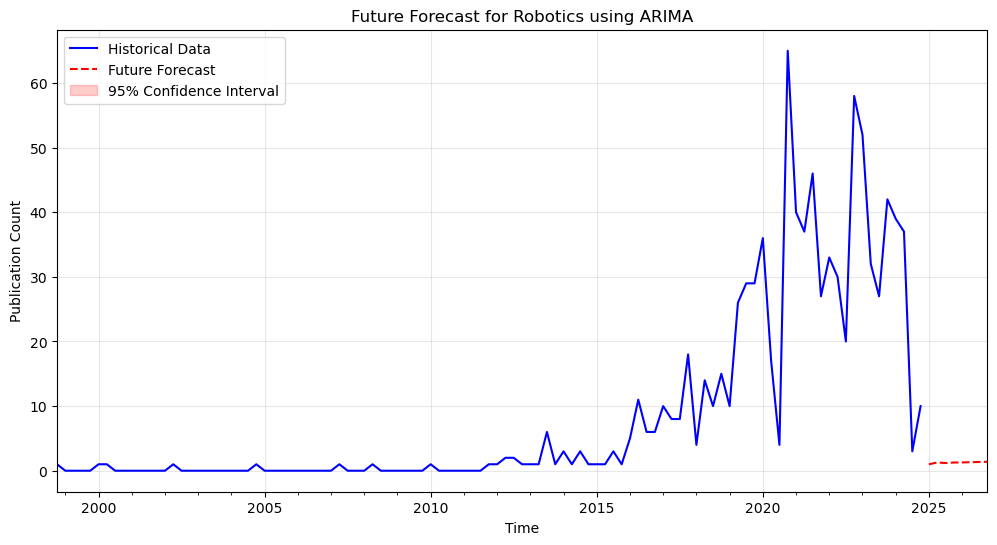


===== Processing Category: Information Retrieval =====

Comparing forecast models for: Information Retrieval
Transformation method: difference
Training set size: 84
Test set size: 21
ARIMA - RMSE: 21.64, MAPE: 129.11%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Information Retrieval: ARIMA
RMSE: 21.64, MAPE: 129.11%

Generating future forecast for Information Retrieval using ARIMA...


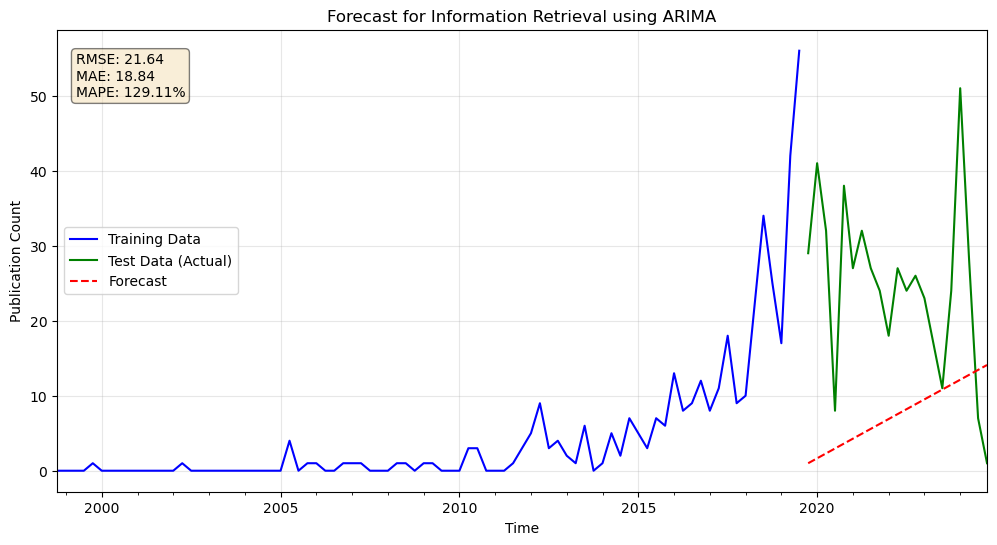

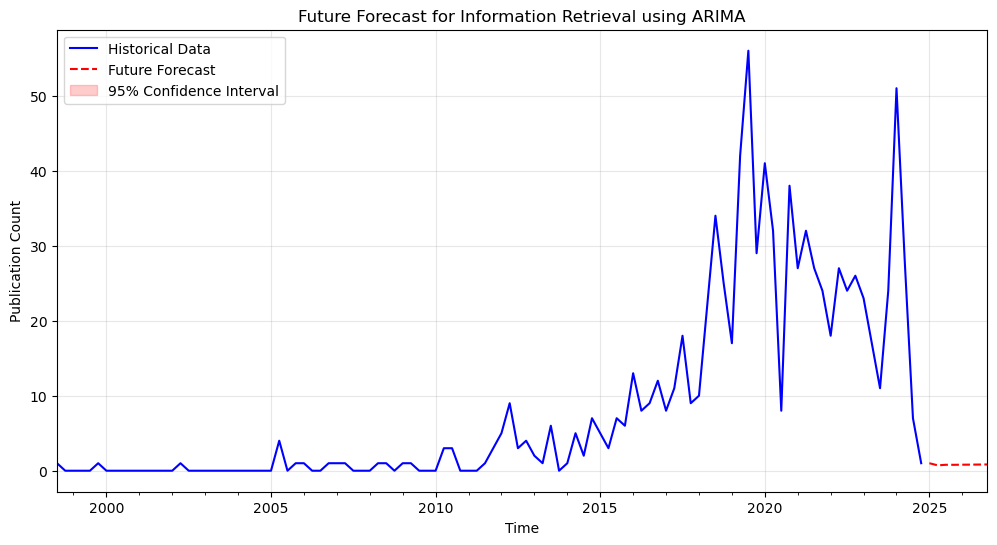


===== Processing Category: Methodology (Statistics) =====

Comparing forecast models for: Methodology (Statistics)
Transformation method: difference
Training set size: 56
Test set size: 14
ARIMA - RMSE: 17.45, MAPE: 108.51%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Methodology (Statistics): ARIMA
RMSE: 17.45, MAPE: 108.51%

Generating future forecast for Methodology (Statistics) using ARIMA...


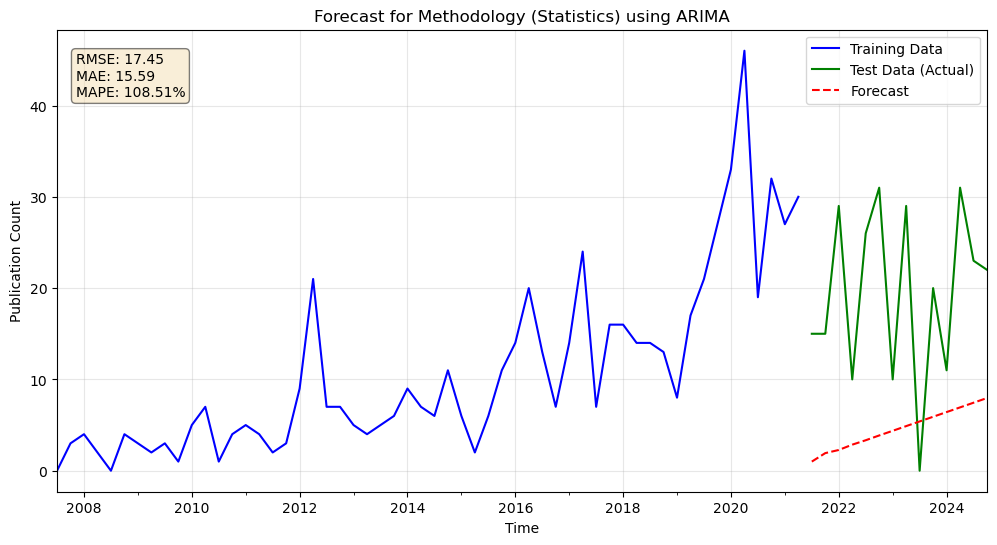

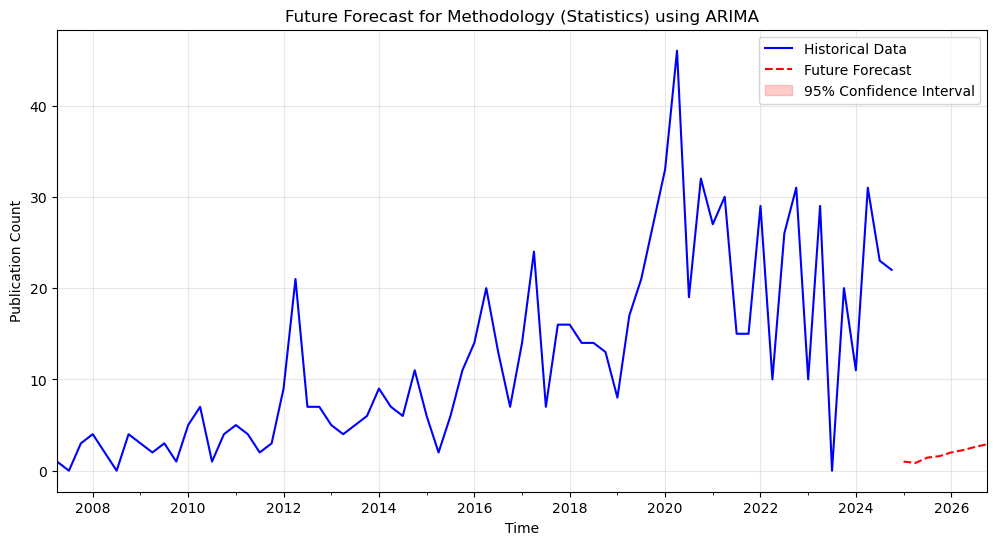


===== Processing Category: Computation and Language (Legacy category) =====

Comparing forecast models for: Computation and Language (Legacy category)
Transformation method: seasonal_difference
Training set size: 9
Test set size: 3
ARIMA - RMSE: 47.33, MAPE: 2450.00%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Computation and Language (Legacy category): ARIMA
RMSE: 47.33, MAPE: 2450.00%

Generating future forecast for Computation and Language (Legacy category) using ARIMA...


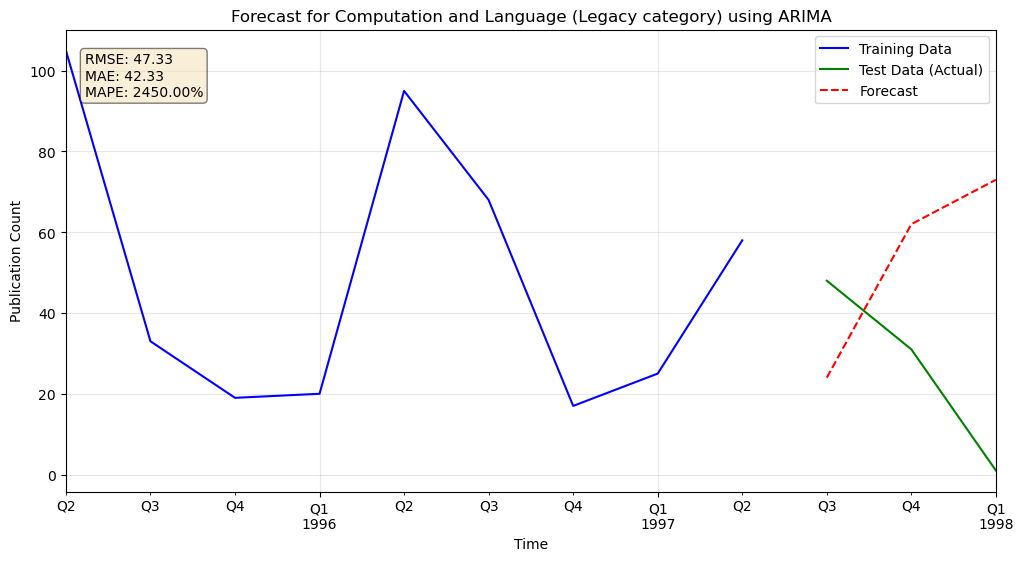

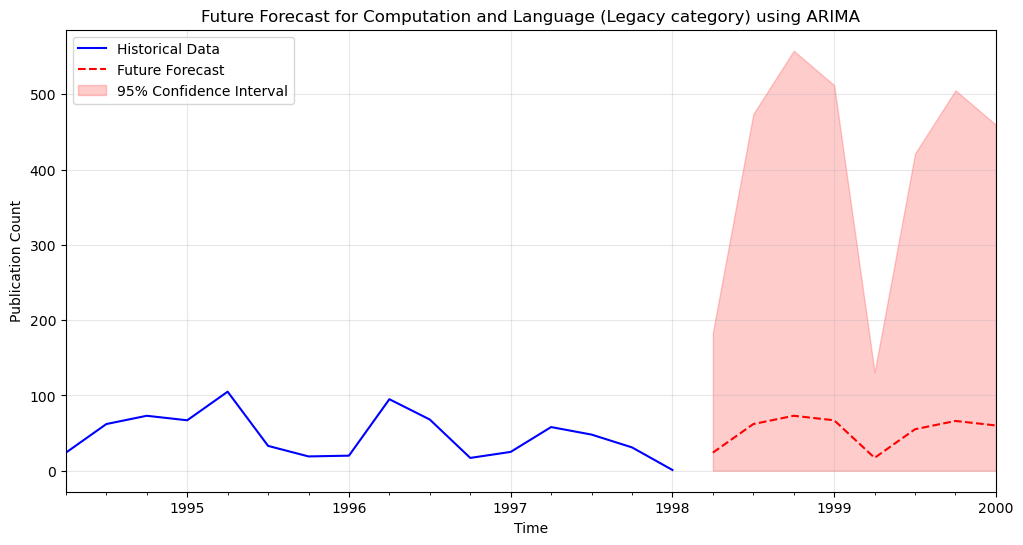


===== Processing Category: Optimization and Control =====

Comparing forecast models for: Optimization and Control
Transformation method: twice_difference
Training set size: 58
Test set size: 15
ARIMA - RMSE: 31.12, MAPE: 336.90%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Optimization and Control: ARIMA
RMSE: 31.12, MAPE: 336.90%

Generating future forecast for Optimization and Control using ARIMA...


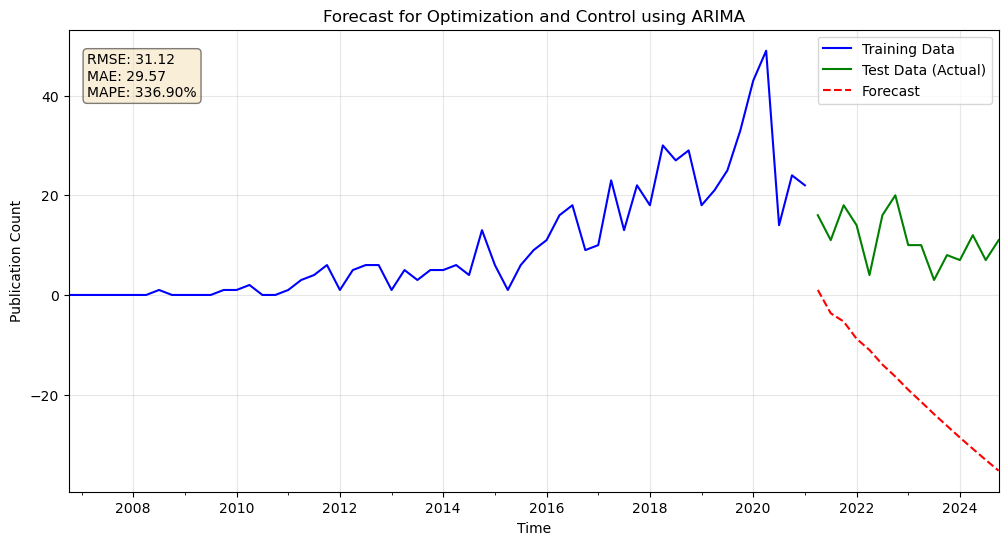

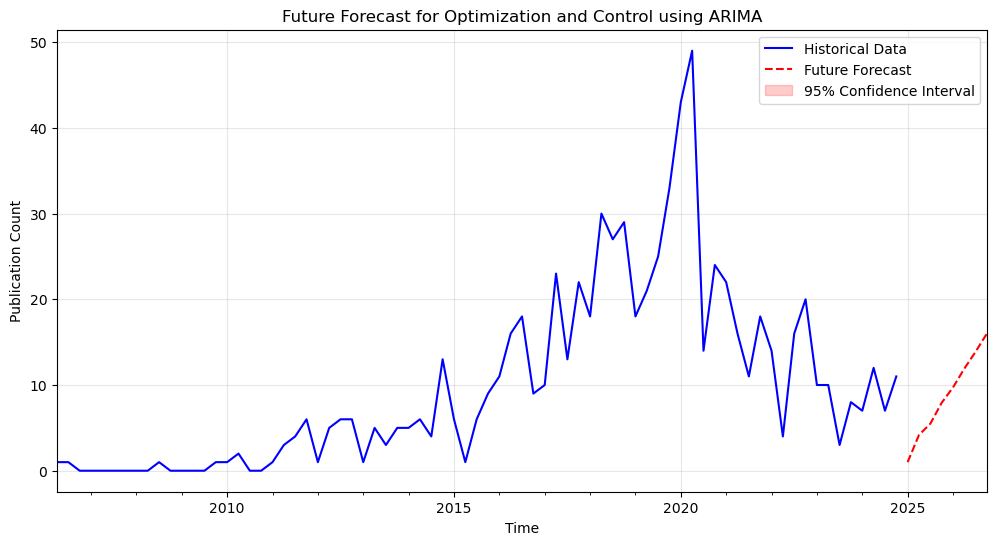


===== Processing Category: Cryptography and Security =====

Comparing forecast models for: Cryptography and Security
Transformation method: log_difference
Training set size: 70
Test set size: 18
ARIMA - RMSE: 22.13, MAPE: 96.49%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Cryptography and Security: ARIMA
RMSE: 22.13, MAPE: 96.49%

Generating future forecast for Cryptography and Security using ARIMA...


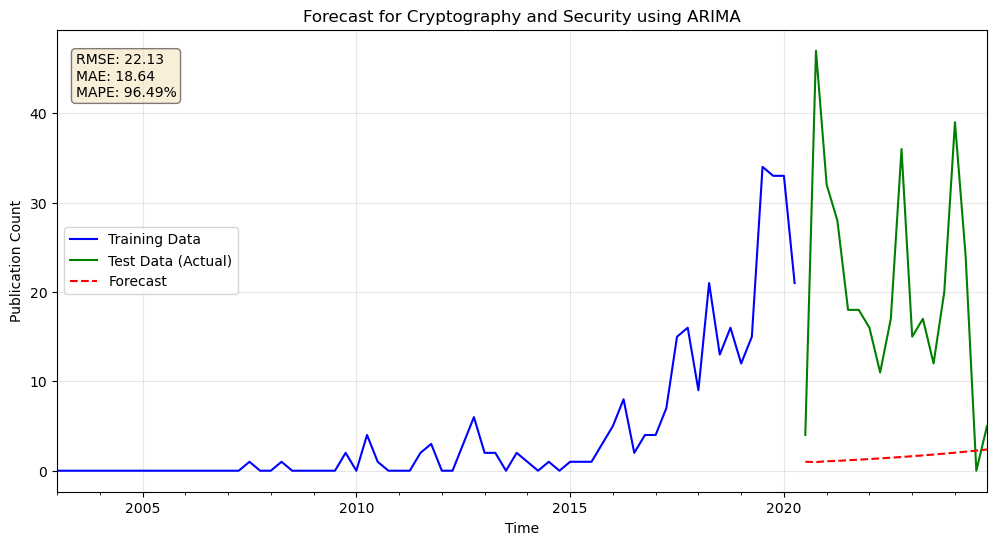

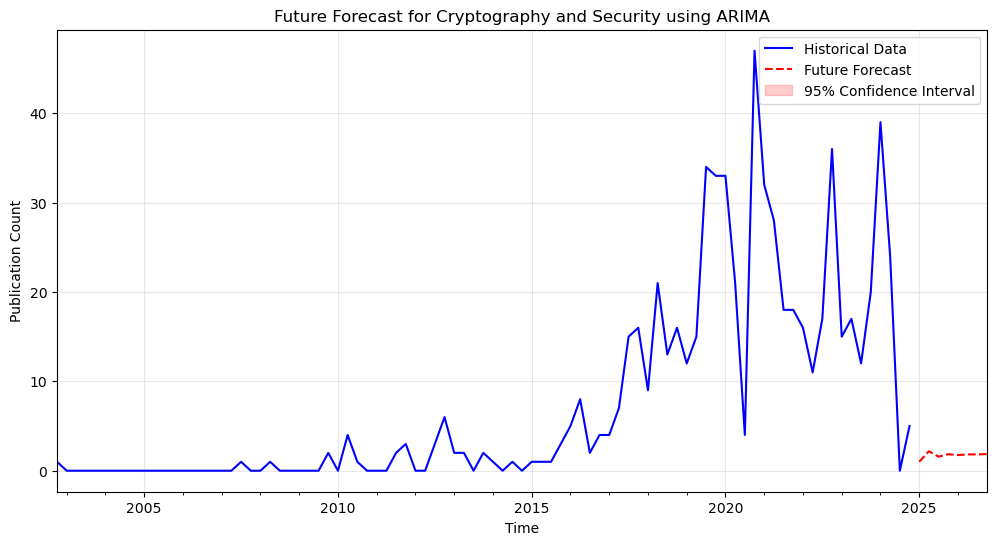


===== Processing Category: Computers and Society =====

Comparing forecast models for: Computers and Society
Transformation method: log_difference
Training set size: 55
Test set size: 14
ARIMA - RMSE: 19.48, MAPE: 88.30%
SARIMA model failed: Seasonal periodicity must be greater than 1.
Exponential Smoothing model failed: seasonal_periods must be larger than 1.

Best model for Computers and Society: ARIMA
RMSE: 19.48, MAPE: 88.30%

Generating future forecast for Computers and Society using ARIMA...


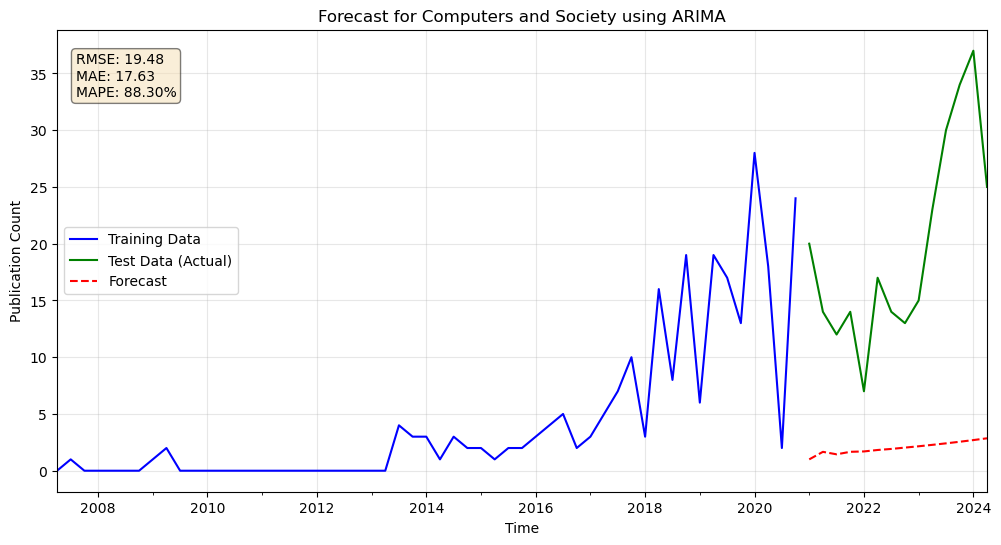

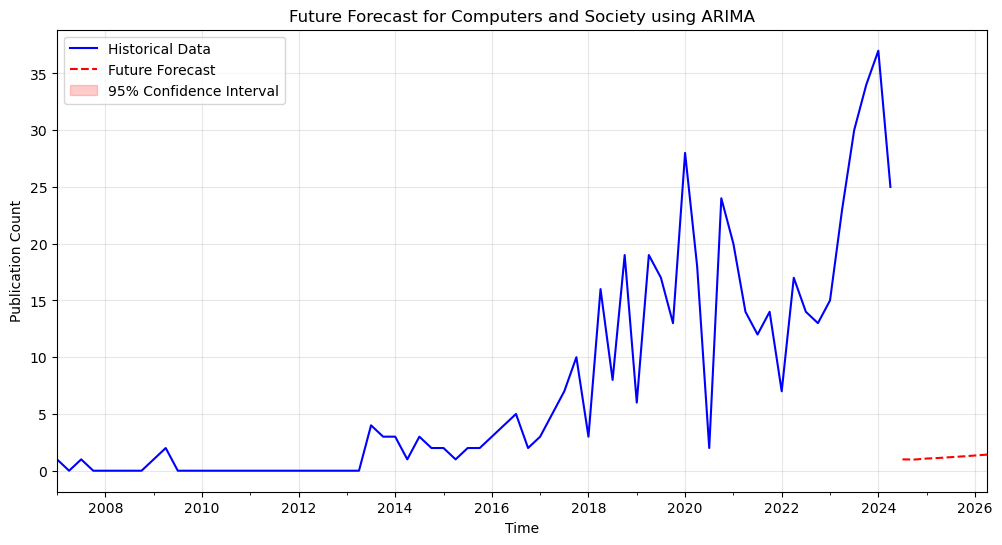

In [28]:
# Let's set up a loop to analyze each category
best_models = {}
model_comparisons = {}
future_forecasts = {}

# Loop through the top categories
for category in top_categories:
    print(f"\n===== Processing Category: {category} =====")
    
    # Check if this category has transformation results
    if category not in transformation_results['results']:
        print(f"Skipping {category}: No transformation results available")
        continue
    
    # Get the transformation details
    category_result = transformation_results['results'][category]
    transformation_method = category_result['best_method']
    
    # Get the transformed series
    if category not in transformation_results['transformed_series']:
        print(f"Skipping {category}: No transformed series available")
        continue
    
    transformed_series = transformation_results['transformed_series'][category]
    
    # Get the original time series
    category_df = filtered_df[filtered_df['category'] == category]
    original_series = category_df.groupby(pd.Grouper(key='published_date', freq='QE')).size()
    
    # Compare forecasting models
    model_comparison = compare_forecast_models(
        category=category,
        transformed_series=transformed_series,
        original_series=original_series,
        transformation_method=transformation_method,
        test_size=0.2,
        freq='QE'  # Make sure this matches what you used for transformation
    )
    
    # Store results
    model_comparisons[category] = model_comparison
    
    # If we have a best model, store it
    if model_comparison['best_model']:
        best_models[category] = model_comparison['best_model']
        
        # Generate future forecast using the best model
        forecast, fig = forecast_future_periods(
            category=category,
            best_model_name=model_comparison['best_model'],
            transformation_method=transformation_method,
            transformed_series=transformed_series,
            original_series=original_series,
            n_periods=8,  # 2 years (8 quarters)
            freq='QE'
        )
        
        # Store the forecast
        future_forecasts[category] = forecast
        
        # Display the future forecast plot
        plt.figure(fig.number)
        plt.show()

In [30]:
# Step 3: Create a summary of growth rates
if future_forecasts:
    growth_summary = create_growth_rate_summary(
        categories=top_categories,
        future_forecasts=future_forecasts,
        original_data=filtered_df,
        n_periods=8,
        freq='QE'
    )
    
    print("\nFuture Growth Rates:")
    display(growth_summary)
    
    # Display categories by growth trend
    print("\nCategories Expected to Grow:")
    display(growth_summary[growth_summary['Growth Rate (%)'] > 0])
    
    print("\nCategories Expected to Decline:")
    display(growth_summary[growth_summary['Growth Rate (%)'] <= 0])


Future Growth Rates:


Category  Current Value  \
9          Computation and Language (Legacy category)              1   
10                           Optimization and Control             11   
7                               Information Retrieval              1   
11                          Cryptography and Security              5   
5                   Neural and Evolutionary Computing            200   
6                                            Robotics             10   
8                            Methodology (Statistics)             22   
1             Computer Vision and Pattern Recognition             23   
12                              Computers and Society             25   
2   Computation and Language (Natural Language Pro...            302   
4                       Machine Learning (Statistics)            198   
0                                    Machine Learning           1094   
3                             Artificial Intelligence            554   

    Forecast in 8 periods  Growth Rate (%)  
9               60.122806      5912.280640  
10              16.030022        45.727474  
7                0.835144       -16.485602  
11               1.857407       -62.851865  
5               34.929600       -82.535200  
6                1.385774       -86.142261  
8                2.899949       -86.818414  
1                2.819259       -87.742351  
12               1.418564       -94.325743  
2               14.916550       -95.060745  
4                6.035449       -96.951793  
0                3.036330       -99.722456  
3             -411.282481      -174.238715


Categories Expected to Grow:


Category  Current Value  \
9   Computation and Language (Legacy category)              1   
10                    Optimization and Control             11   

    Forecast in 8 periods  Growth Rate (%)  
9               60.122806      5912.280640  
10              16.030022        45.727474


Categories Expected to Decline:


Category  Current Value  \
7                               Information Retrieval              1   
11                          Cryptography and Security              5   
5                   Neural and Evolutionary Computing            200   
6                                            Robotics             10   
8                            Methodology (Statistics)             22   
1             Computer Vision and Pattern Recognition             23   
12                              Computers and Society             25   
2   Computation and Language (Natural Language Pro...            302   
4                       Machine Learning (Statistics)            198   
0                                    Machine Learning           1094   
3                             Artificial Intelligence            554   

    Forecast in 8 periods  Growth Rate (%)  
7                0.835144       -16.485602  
11               1.857407       -62.851865  
5               34.929600       -82.535200  
6                1.385774       -86.142261  
8                2.899949       -86.818414  
1                2.819259       -87.742351  
12               1.418564       -94.325743  
2               14.916550       -95.060745  
4                6.035449       -96.951793  
0                3.036330       -99.722456  
3             -411.282481      -174.238715

In [31]:
# First, let's check what freq your data actually has
print(f"Transformed series frequency: {transformed_series.index.freq}")
print(f"Original series frequency: {original_series.index.freq}")

Transformed series frequency: <QuarterEnd: startingMonth=12>
Original series frequency: <QuarterEnd: startingMonth=12>


# Conclusions from attempt 1
The SARIMA model is not useful. The ARIMA model was used every time, but the forecasting is abysmal. 

Trying different ARIMA orders to see if we can improve. 

In [45]:
# Define a range of ARIMA orders to test
arima_orders = [(1,0,0), (2,0,0), (0,0,1), (1,0,1), (2,0,2), (3,0,0), (0,0,2)]

# Dictionary to store best models and metrics
best_arima_models = {}
best_arima_metrics = {}

# Loop through each category
for category in top_categories:
    print(f"\n===== Processing Category: {category} =====")
    
    if category not in transformation_results['transformed_series']:
        print(f"Skipping {category}: No transformed series available")
        continue
        
    transformed_series = transformation_results['transformed_series'][category]
    category_df = filtered_df[filtered_df['category'] == category]
    original_series = category_df.groupby(pd.Grouper(key='published_date', freq='QE')).size()
    transformation_method = transformation_results['results'][category]['best_method']
    
    print(f"Transformation method: {transformation_method}")
    print(f"Number of data points: {len(original_series)}")
    
    # Train-test split
    train_transformed, test_transformed = train_test_split_time_series(transformed_series, test_size=0.2)
    train_original = original_series.loc[train_transformed.index]
    test_original = original_series.loc[test_transformed.index]
    
    print(f"Training set size: {len(train_transformed)}")
    print(f"Test set size: {len(test_transformed)}")
    
    # Test each ARIMA order
    best_rmse = float('inf')
    best_order = None
    best_forecast = None
    
    print("\nTesting different ARIMA orders:")
    for order in arima_orders:
        try:
            # Fit model
            model = fit_arima_model(train_transformed, order=order)
            
            # Forecast
            forecast_transformed = model.predict(
                start=test_transformed.index[0],
                end=test_transformed.index[-1]
            )
            
            # Convert back to original scale
            forecast = pd.Series(
                inverse_transform(forecast_transformed, original_series, transformation_method),
                index=test_transformed.index
            )
            
            # Evaluate
            metrics = evaluate_forecast(test_original, forecast, f"ARIMA{order}")
            
            # Print results for this order
            print(f"  ARIMA{order}: RMSE={metrics['rmse']:.2f}, MAPE={metrics['mape']:.2f}%")
            
            # Check if this is the best model so far
            if metrics['rmse'] < best_rmse:
                best_rmse = metrics['rmse']
                best_order = order
                best_forecast = forecast
                best_metrics = metrics
                
        except Exception as e:
            print(f"  ARIMA{order} failed: {str(e)}")
    
    # After trying all orders, store and print the best one for this category
    if best_order:
        best_arima_models[category] = best_order
        best_arima_metrics[category] = best_metrics
        print(f"\nBest ARIMA order for {category}: {best_order}")
        print(f"Best RMSE: {best_rmse:.2f}, MAPE: {best_metrics['mape']:.2f}%")
    else:
        print(f"\nNo successful ARIMA model for {category}")

# After processing all categories, print a summary
print("\n===== Summary of Best ARIMA Models =====")
for category, order in best_arima_models.items():
    metrics = best_arima_metrics[category]
    print(f"{category}: ARIMA{order} - RMSE={metrics['rmse']:.2f}, MAPE={metrics['mape']:.2f}%")


===== Processing Category: Machine Learning =====
Transformation method: log_difference
Number of data points: 104
Training set size: 82
Test set size: 21

Testing different ARIMA orders:
  ARIMA(1, 0, 0): RMSE=1326.94, MAPE=99.60%
  ARIMA(2, 0, 0): RMSE=1326.27, MAPE=99.53%
  ARIMA(0, 0, 1): RMSE=1325.52, MAPE=99.46%
  ARIMA(1, 0, 1): RMSE=1325.20, MAPE=99.43%
  ARIMA(2, 0, 2): RMSE=1324.73, MAPE=99.38%
  ARIMA(3, 0, 0): RMSE=1326.07, MAPE=99.51%
  ARIMA(0, 0, 2): RMSE=1325.09, MAPE=99.41%

Best ARIMA order for Machine Learning: (2, 0, 2)
Best RMSE: 1324.73, MAPE: 99.38%

===== Processing Category: Computer Vision and Pattern Recognition =====
Transformation method: log_difference
Number of data points: 105
Training set size: 83
Test set size: 21

Testing different ARIMA orders:
  ARIMA(1, 0, 0): RMSE=786.21, MAPE=93.07%
  ARIMA(2, 0, 0): RMSE=785.91, MAPE=92.19%
  ARIMA(0, 0, 1): RMSE=785.14, MAPE=91.27%
  ARIMA(1, 0, 1): RMSE=785.55, MAPE=91.16%
  ARIMA(2, 0, 2): RMSE=785.47, MAPE=

# Arima parameters 

These vary from category to category. Will try to do specific forecasting this way.


===== Validating Models with In-Sample Forecasting =====

Evaluating Machine Learning with ARIMA(2, 0, 2)...


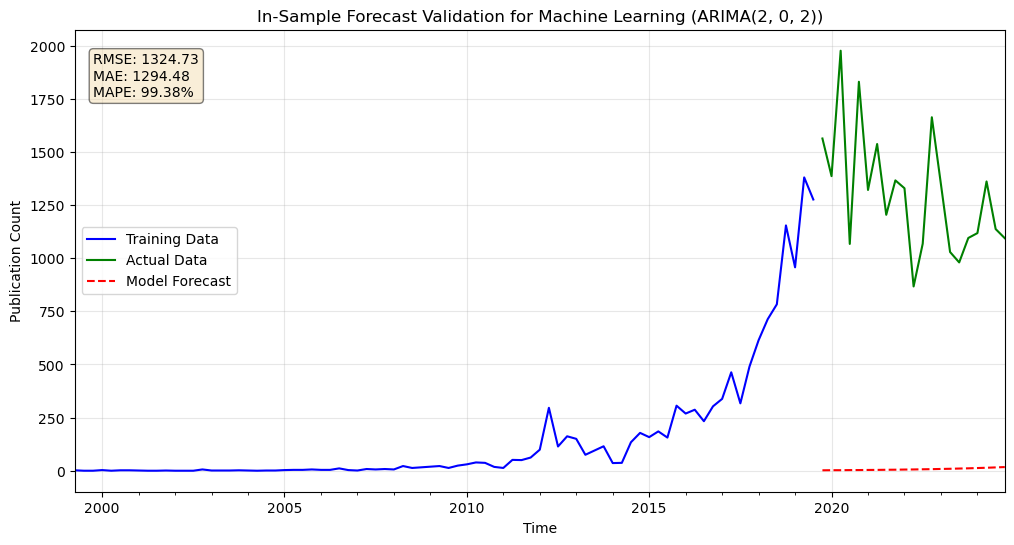

Evaluation metrics: RMSE=1324.73, MAPE=99.38%

Evaluating Computer Vision and Pattern Recognition with ARIMA(0, 0, 1)...


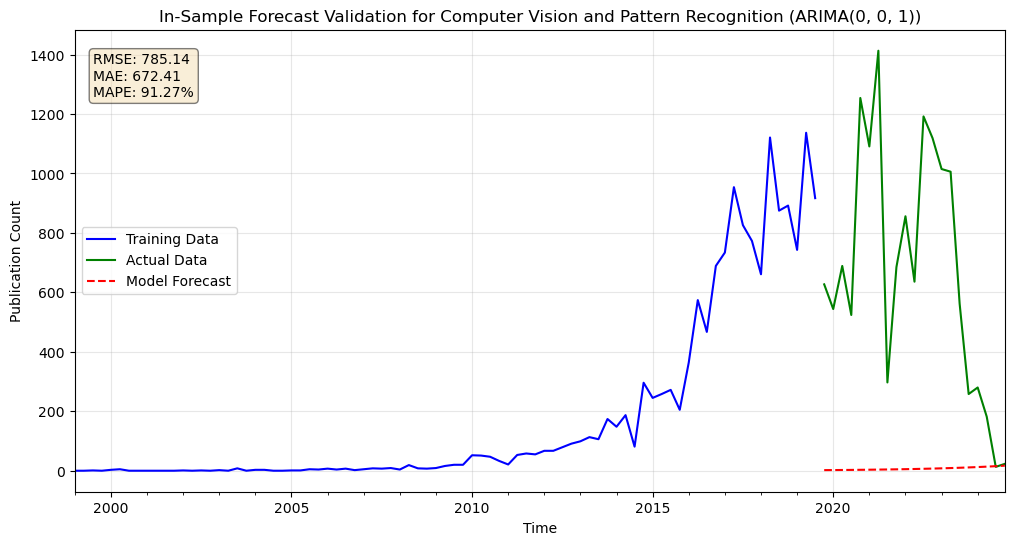

Evaluation metrics: RMSE=785.14, MAPE=91.27%

Evaluating Computation and Language (Natural Language Processing) with ARIMA(2, 0, 2)...


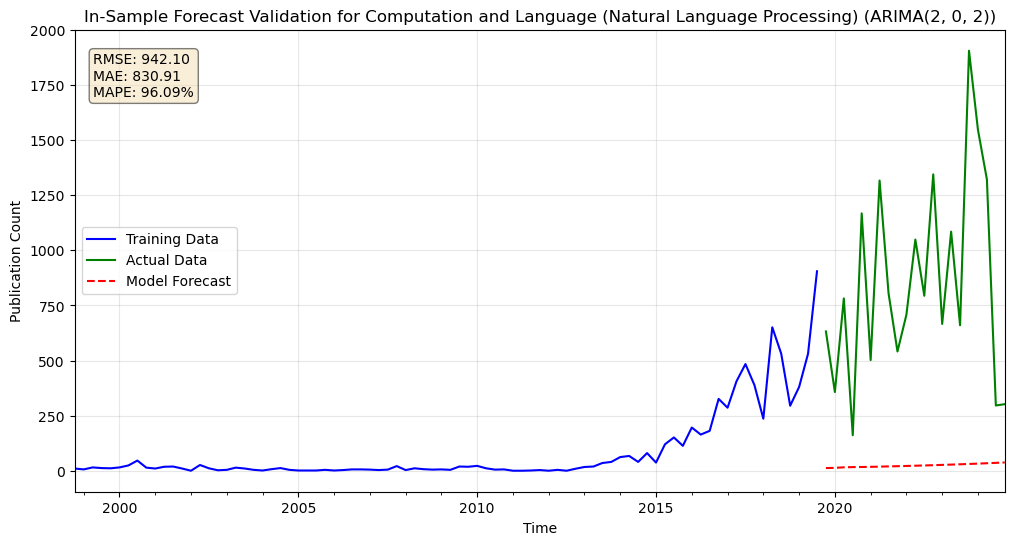

Evaluation metrics: RMSE=942.10, MAPE=96.09%

Evaluating Artificial Intelligence with ARIMA(0, 0, 1)...


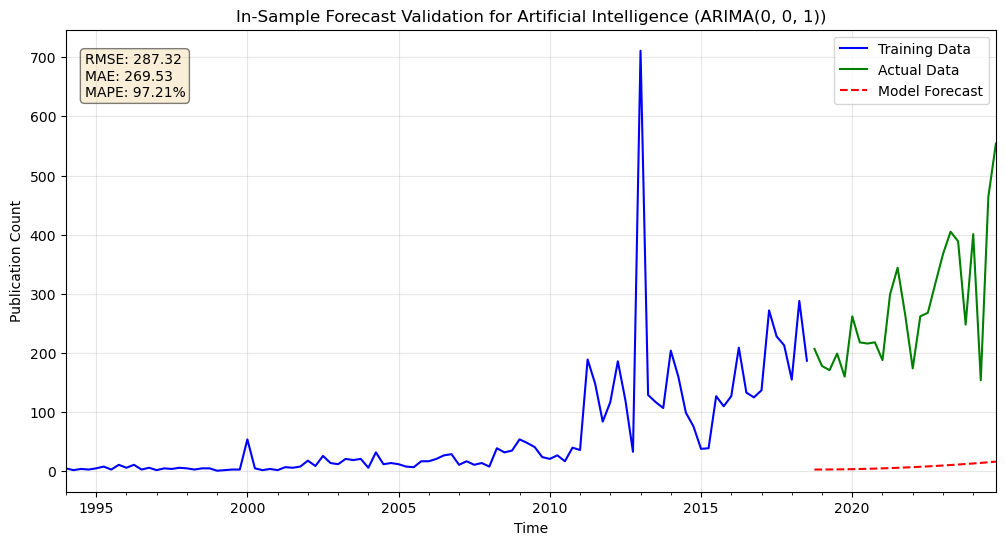

Evaluation metrics: RMSE=287.32, MAPE=97.21%

Evaluating Machine Learning (Statistics) with ARIMA(2, 0, 2)...


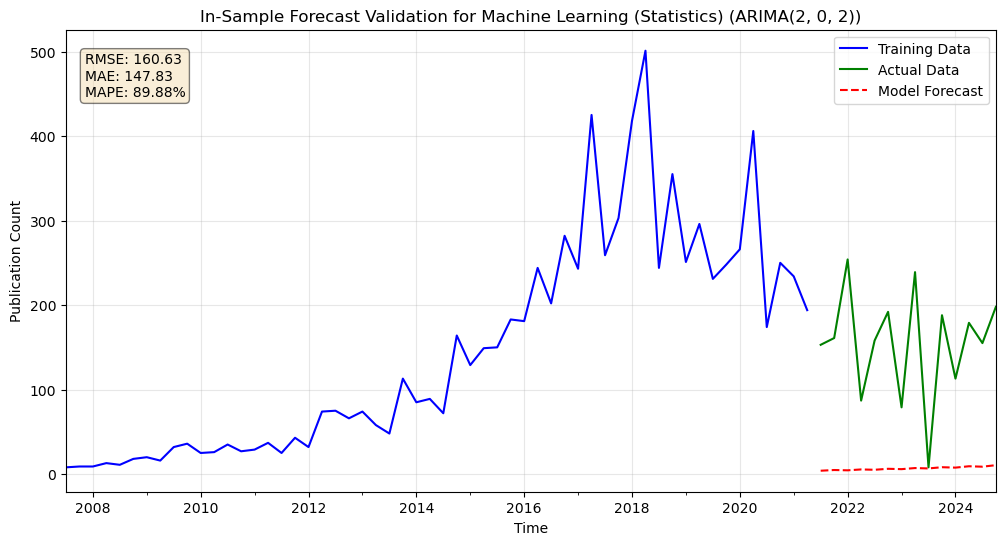

Evaluation metrics: RMSE=160.63, MAPE=89.88%

Evaluating Neural and Evolutionary Computing with ARIMA(3, 0, 0)...


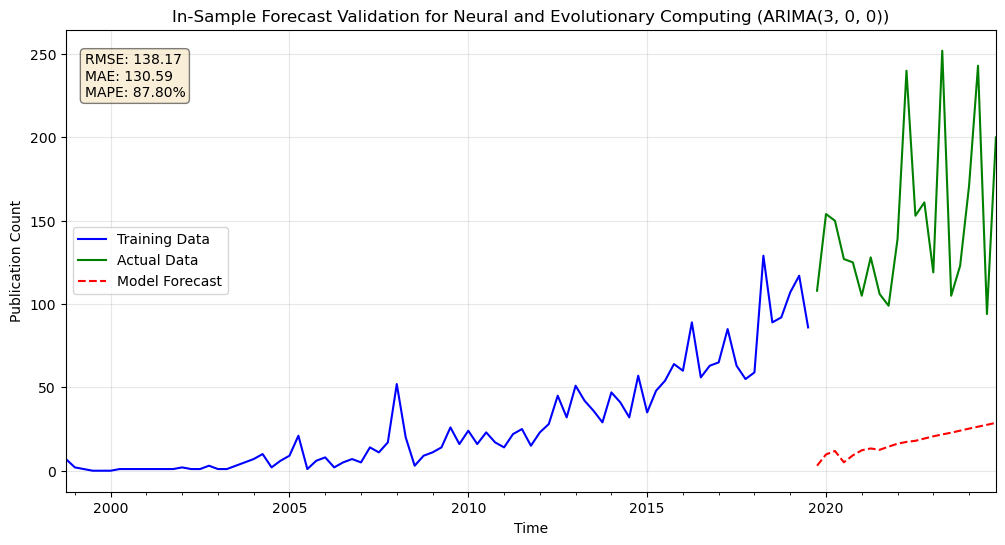

Evaluation metrics: RMSE=138.17, MAPE=87.80%

Evaluating Robotics with ARIMA(2, 0, 0)...


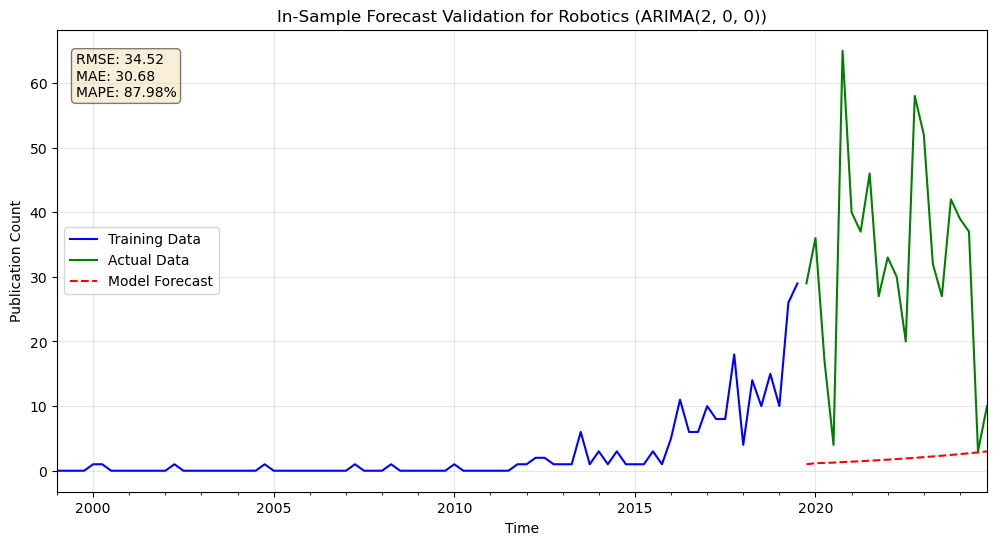

Evaluation metrics: RMSE=34.52, MAPE=87.98%

Evaluating Information Retrieval with ARIMA(2, 0, 0)...


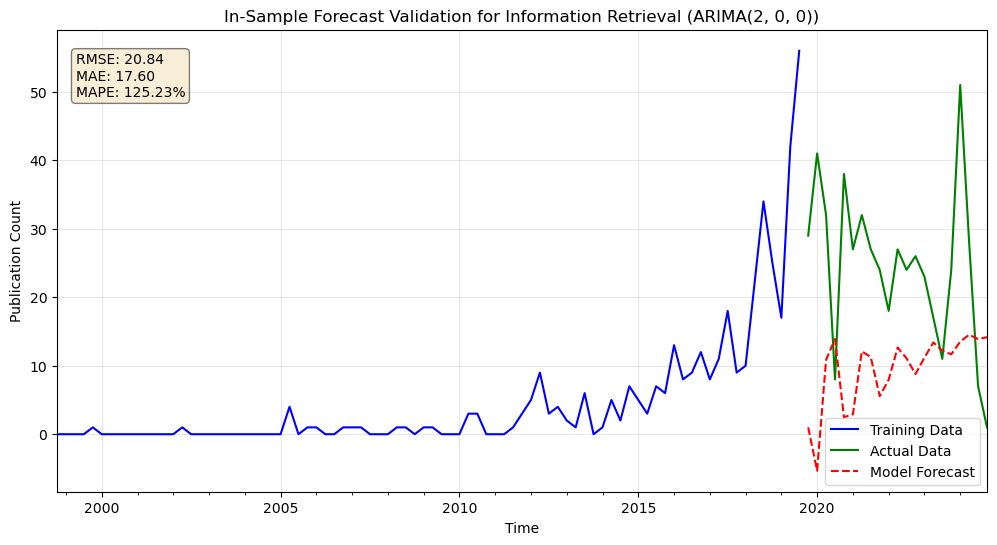

Evaluation metrics: RMSE=20.84, MAPE=125.23%

Evaluating Methodology (Statistics) with ARIMA(3, 0, 0)...


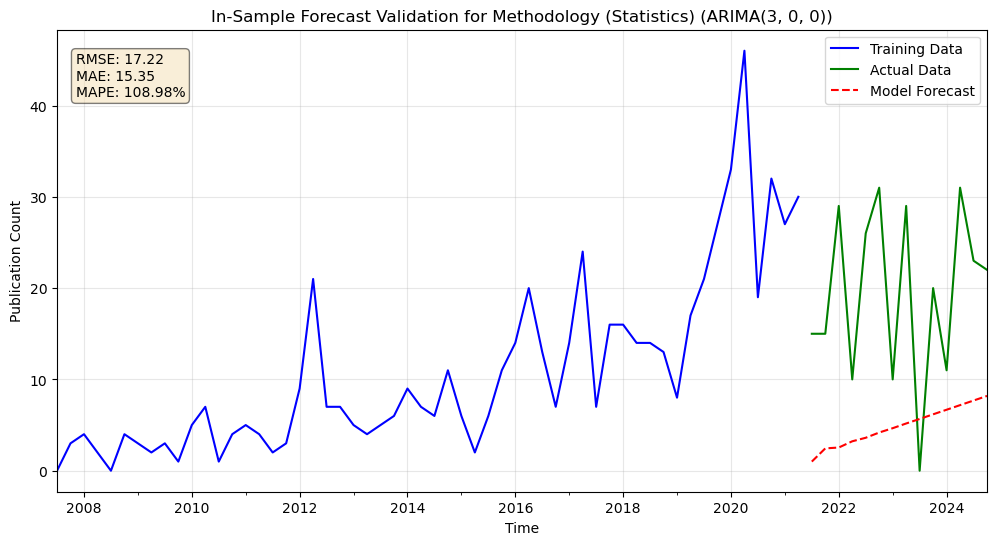

Evaluation metrics: RMSE=17.22, MAPE=108.98%

Evaluating Computation and Language (Legacy category) with ARIMA(1, 0, 0)...


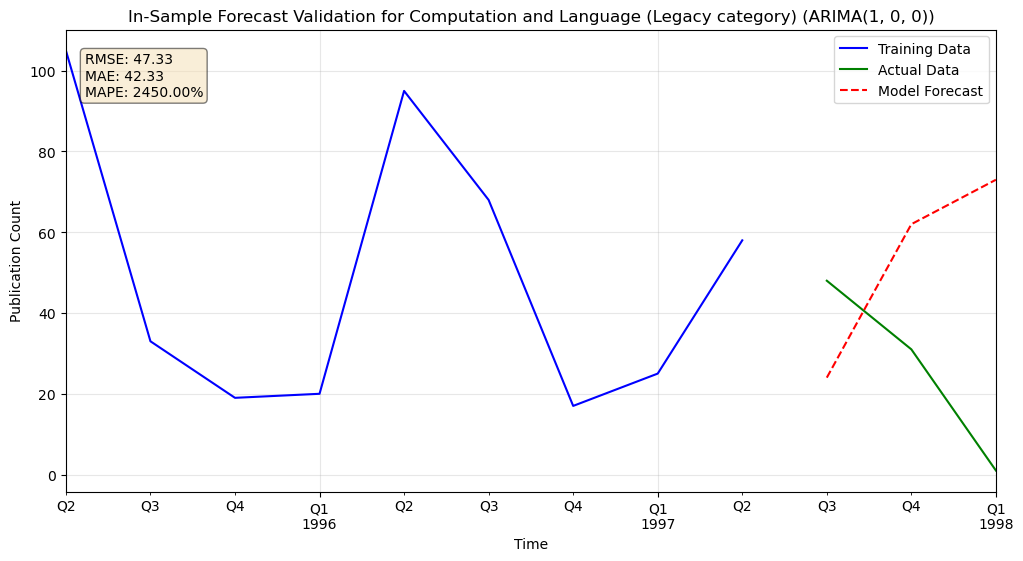

Evaluation metrics: RMSE=47.33, MAPE=2450.00%

Evaluating Optimization and Control with ARIMA(0, 0, 1)...


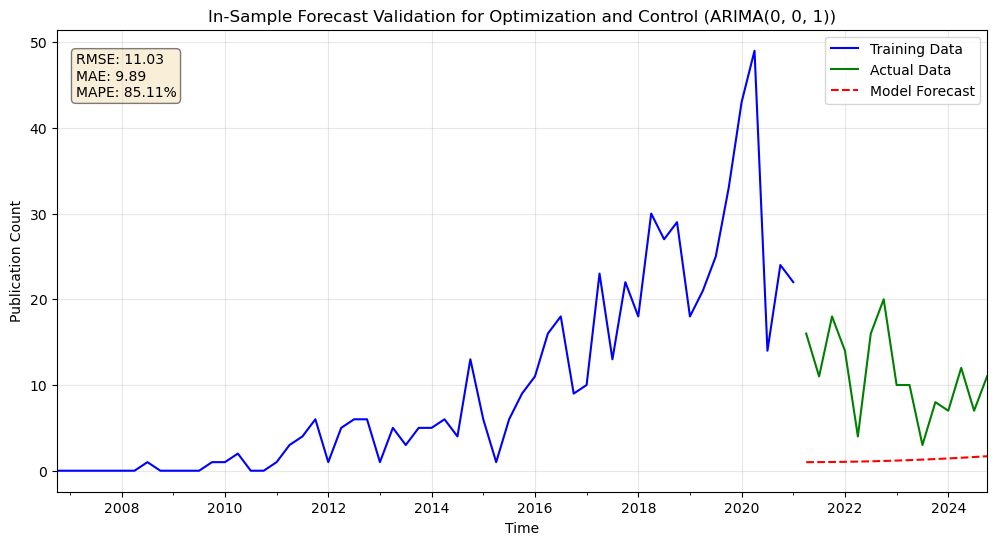

Evaluation metrics: RMSE=11.03, MAPE=85.11%

Evaluating Cryptography and Security with ARIMA(0, 0, 2)...


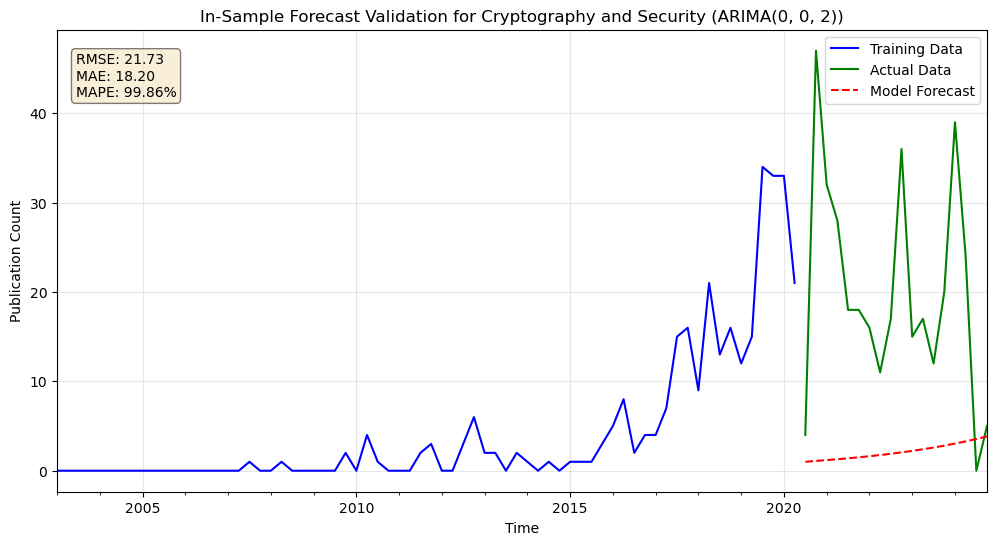

Evaluation metrics: RMSE=21.73, MAPE=99.86%

Evaluating Computers and Society with ARIMA(2, 0, 2)...


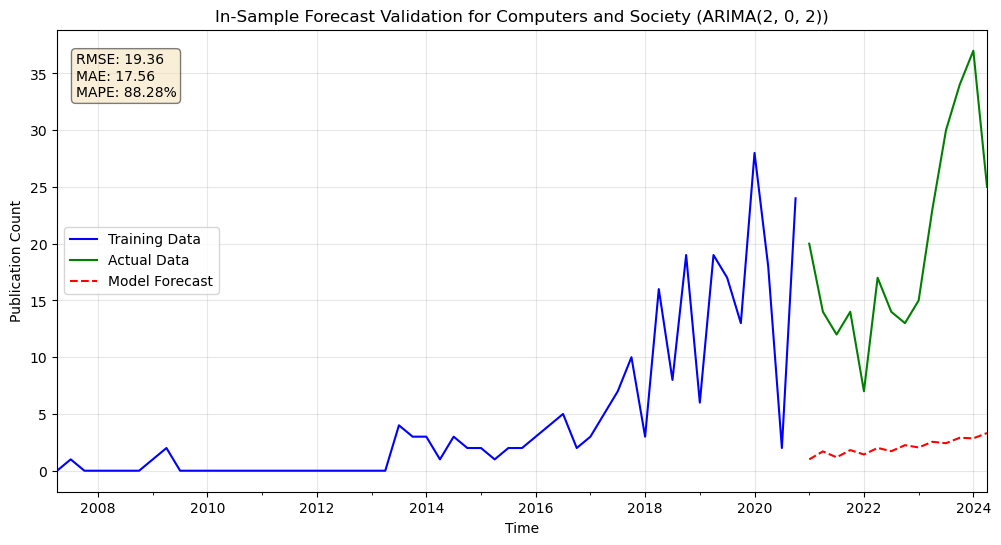

Evaluation metrics: RMSE=19.36, MAPE=88.28%

===== Model Validation Summary =====


Category ARIMA Order  \
10                           Optimization and Control   (0, 0, 1)   
5                   Neural and Evolutionary Computing   (3, 0, 0)   
6                                            Robotics   (2, 0, 0)   
12                              Computers and Society   (2, 0, 2)   
4                       Machine Learning (Statistics)   (2, 0, 2)   
1             Computer Vision and Pattern Recognition   (0, 0, 1)   
2   Computation and Language (Natural Language Pro...   (2, 0, 2)   
3                             Artificial Intelligence   (0, 0, 1)   
0                                    Machine Learning   (2, 0, 2)   
11                          Cryptography and Security   (0, 0, 2)   
8                            Methodology (Statistics)   (3, 0, 0)   
7                               Information Retrieval   (2, 0, 0)   
9          Computation and Language (Legacy category)   (1, 0, 0)   

           RMSE          MAE     MAPE (%)  
10    11.033092     9.888008    85.107982  
5    138.170604   130.592440    87.802958  
6     34.516676    30.683990    87.984383  
12    19.363735    17.556811    88.275409  
4    160.625298   147.828064    89.876383  
1    785.140439   672.414680    91.268040  
2    942.099115   830.911228    96.089958  
3    287.320476   269.530626    97.212046  
0   1324.734692  1294.477692    99.380729  
11    21.726440    18.198446    99.858998  
8     17.218240    15.351151   108.978288  
7     20.841084    17.597415   125.230841  
9     47.332160    42.333333  2450.000000


Categories with Unreliable Models (MAPE ≥ 30%):


Category ARIMA Order  \
10                           Optimization and Control   (0, 0, 1)   
5                   Neural and Evolutionary Computing   (3, 0, 0)   
6                                            Robotics   (2, 0, 0)   
12                              Computers and Society   (2, 0, 2)   
4                       Machine Learning (Statistics)   (2, 0, 2)   
1             Computer Vision and Pattern Recognition   (0, 0, 1)   
2   Computation and Language (Natural Language Pro...   (2, 0, 2)   
3                             Artificial Intelligence   (0, 0, 1)   
0                                    Machine Learning   (2, 0, 2)   
11                          Cryptography and Security   (0, 0, 2)   
8                            Methodology (Statistics)   (3, 0, 0)   
7                               Information Retrieval   (2, 0, 0)   
9          Computation and Language (Legacy category)   (1, 0, 0)   

           RMSE          MAE     MAPE (%)  
10    11.033092     9.888008    85.107982  
5    138.170604   130.592440    87.802958  
6     34.516676    30.683990    87.984383  
12    19.363735    17.556811    88.275409  
4    160.625298   147.828064    89.876383  
1    785.140439   672.414680    91.268040  
2    942.099115   830.911228    96.089958  
3    287.320476   269.530626    97.212046  
0   1324.734692  1294.477692    99.380729  
11    21.726440    18.198446    99.858998  
8     17.218240    15.351151   108.978288  
7     20.841084    17.597415   125.230841  
9     47.332160    42.333333  2450.000000

In [49]:
# Validate models with in-sample forecasting
in_sample_results = {}

print("\n===== Validating Models with In-Sample Forecasting =====")

for category, best_order in best_arima_models.items():
    print(f"\nEvaluating {category} with ARIMA{best_order}...")
    
    # Get necessary data
    transformed_series = transformation_results['transformed_series'][category]
    category_df = filtered_df[filtered_df['category'] == category]
    original_series = category_df.groupby(pd.Grouper(key='published_date', freq='QE')).size()
    transformation_method = transformation_results['results'][category]['best_method']
    
    try:
        # Use 80% of data for training, 20% for in-sample validation
        train_transformed, test_transformed = train_test_split_time_series(transformed_series, test_size=0.2)
        train_original = original_series.loc[train_transformed.index]
        test_original = original_series.loc[test_transformed.index]
        
        # Fit ARIMA model with the best order on the training data
        model = fit_arima_model(train_transformed, order=best_order)
        
        # Generate in-sample forecast for the testing period
        forecast_transformed = model.predict(
            start=test_transformed.index[0],
            end=test_transformed.index[-1]
        )
        
        # Convert back to original scale
        forecast = pd.Series(
            inverse_transform(forecast_transformed, original_series, transformation_method),
            index=test_transformed.index
        )
        
        # Evaluate the forecast
        metrics = evaluate_forecast(test_original, forecast, f"ARIMA{best_order}")
        
        # Store results
        in_sample_results[category] = {
            'order': best_order,
            'forecast': forecast,
            'actual': test_original,
            'metrics': metrics
        }
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot training data
        train_original.plot(ax=ax, label='Training Data', color='blue')
        
        # Plot actual test data
        test_original.plot(ax=ax, label='Actual Data', color='green')
        
        # Plot forecast
        forecast.plot(ax=ax, label='Model Forecast', color='red', linestyle='--')
        
        # Add metrics as text
        metrics_text = (f"RMSE: {metrics['rmse']:.2f}\n"
                       f"MAE: {metrics['mae']:.2f}\n"
                       f"MAPE: {metrics['mape']:.2f}%")
        
        ax.text(0.02, 0.95, metrics_text, transform=ax.transAxes,
              fontsize=10, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Add labels and title
        ax.set_xlabel('Time')
        ax.set_ylabel('Publication Count')
        ax.set_title(f"In-Sample Forecast Validation for {category} (ARIMA{best_order})")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Display the figure
        plt.show()
        
        print(f"Evaluation metrics: RMSE={metrics['rmse']:.2f}, MAPE={metrics['mape']:.2f}%")
        
    except Exception as e:
        print(f"In-sample validation failed: {str(e)}")

# Create summary table of validation results
if in_sample_results:
    validation_summary = pd.DataFrame({
        'Category': list(in_sample_results.keys()),
        'ARIMA Order': [in_sample_results[cat]['order'] for cat in in_sample_results.keys()],
        'RMSE': [in_sample_results[cat]['metrics']['rmse'] for cat in in_sample_results.keys()],
        'MAE': [in_sample_results[cat]['metrics']['mae'] for cat in in_sample_results.keys()],
        'MAPE (%)': [in_sample_results[cat]['metrics']['mape'] for cat in in_sample_results.keys()]
    })
    
    # Sort by MAPE (better models first)
    validation_summary = validation_summary.sort_values('MAPE (%)')
    
    print("\n===== Model Validation Summary =====")
    display(validation_summary)
    
    # Analyze which models are performing well vs poorly
    good_models = validation_summary[validation_summary['MAPE (%)'] < 30]
    poor_models = validation_summary[validation_summary['MAPE (%)'] >= 30]
    
    if not good_models.empty:
        print(f"\nCategories with Reliable Models (MAPE < 30%):")
        display(good_models)
    
    if not poor_models.empty:
        print(f"\nCategories with Unreliable Models (MAPE ≥ 30%):")
        display(poor_models)

# Conculsions

All of these models are unreliable. Perhaps this is not surprising giving the variability in the data- and the fact that the different categories seem to have different characteristics. 

# Try to classify growth, stability and decline

Use a simpler, linear regression approach to identify the growth, stability and decline of the different categories.


===== Category Growth Trend Analysis =====


Category  Publication Count  \
12                              Computers and Society                515   
3                             Artificial Intelligence              12819   
2   Computation and Language (Natural Language Pro...              25196   
5                   Neural and Evolutionary Computing               5456   
0                                    Machine Learning              39735   
6                                            Robotics                902   
7                               Information Retrieval                901   
11                          Cryptography and Security                665   
8                            Methodology (Statistics)                880   
4                       Machine Learning (Statistics)              10355   
10                           Optimization and Control                745   
9          Computation and Language (Legacy category)                746   
1             Computer Vision and Pattern Recognition              29043   

    Recent Average (Last Year)  Growth Rate (%)                    Trend  \
12                       31.50       328.155340            Strong Growth   
3                       393.25       286.531711            Strong Growth   
2                       866.75       264.643197            Strong Growth   
5                       177.00       243.878299            Strong Growth   
0                      1177.50       208.191770            Strong Growth   
6                        22.25       159.007761            Strong Growth   
7                        21.75       155.882353            Strong Growth   
11                       17.00       127.518797            Strong Growth   
8                        21.75        75.482955            Strong Growth   
4                       161.25        10.562530          Moderate Growth   
10                        9.25        -6.879195          Moderate Growth   
9                        34.50       -26.005362  Stable (No Clear Trend)   
1                       124.50       -54.989154          Moderate Growth   

    Is Significant  
12            True  
3             True  
2             True  
5             True  
0             True  
6             True  
7             True  
11            True  
8             True  
4             True  
10            True  
9            False  
1             True


Summary by Trend Type:


Trend  Count
0          Moderate Growth      3
1  Stable (No Clear Trend)      1
2            Strong Growth      9

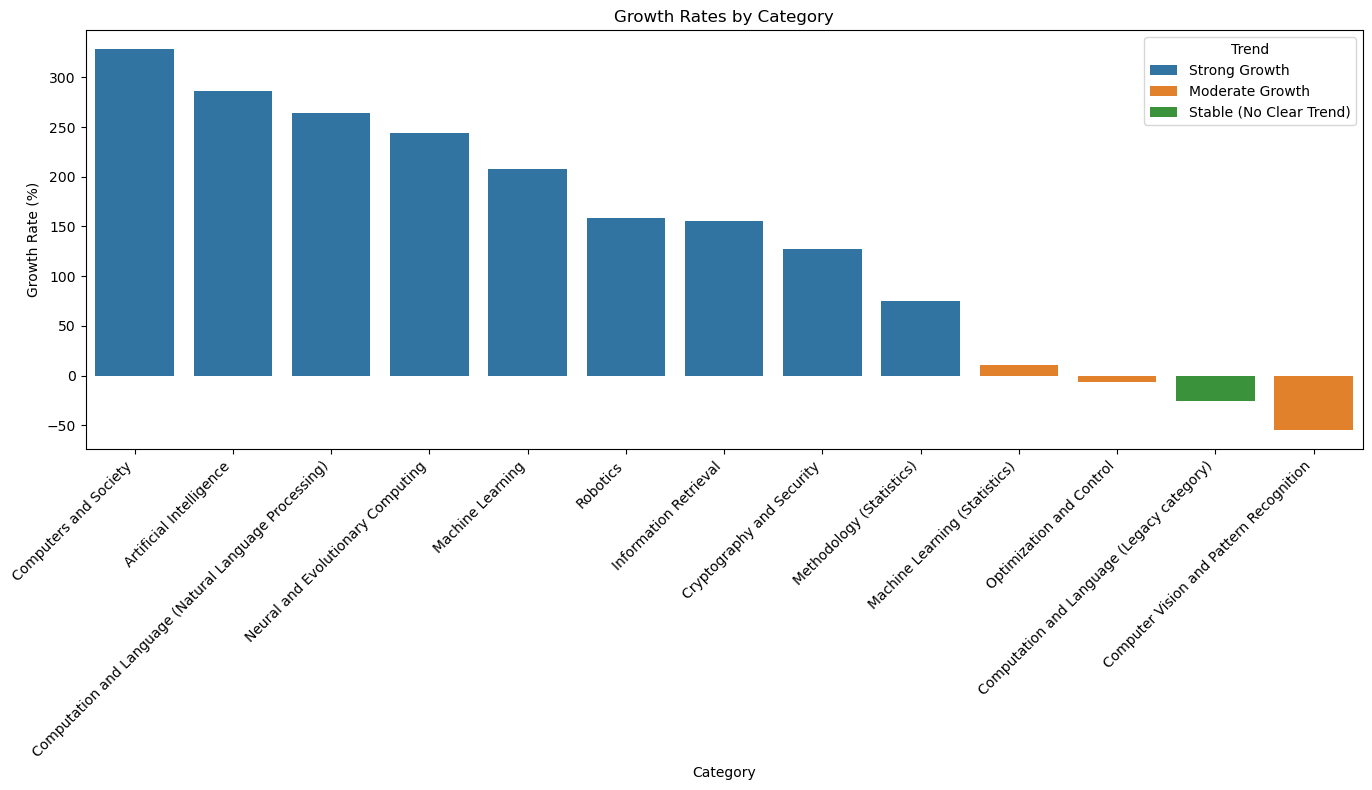

In [54]:
# Now run the analysis
trend_analysis = classify_category_trends(filtered_df, top_categories)

# Display the results
print("\n===== Category Growth Trend Analysis =====")
display(trend_analysis[['Category', 'Publication Count', 'Recent Average (Last Year)', 
                      'Growth Rate (%)', 'Trend', 'Is Significant']])

# Summarize by trend type
trend_summary = trend_analysis.groupby('Trend').size().reset_index(name='Count')
print("\nSummary by Trend Type:")
display(trend_summary)

# Create a visualization of all categories
plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Growth Rate (%)', hue='Trend', data=trend_analysis)
plt.xticks(rotation=45, ha='right')
plt.title('Growth Rates by Category')
plt.tight_layout()
plt.show()

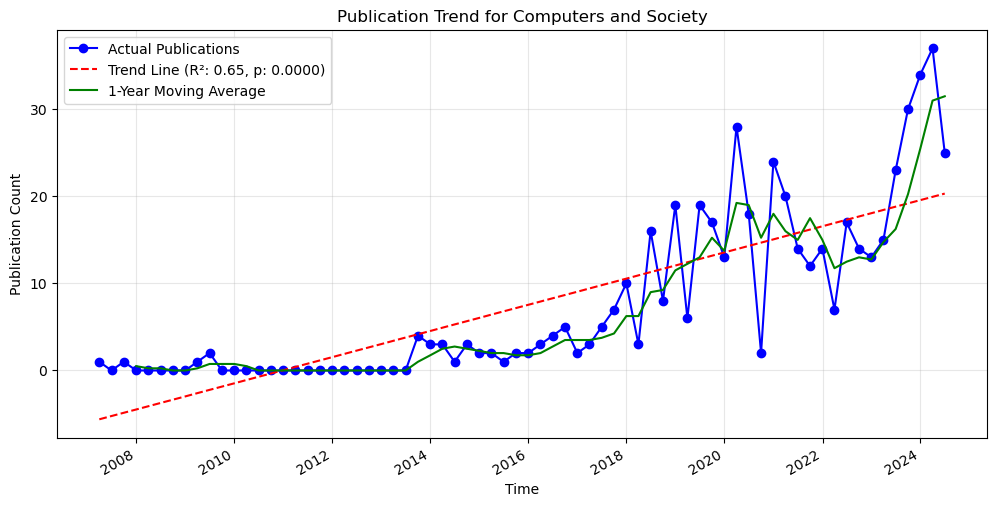

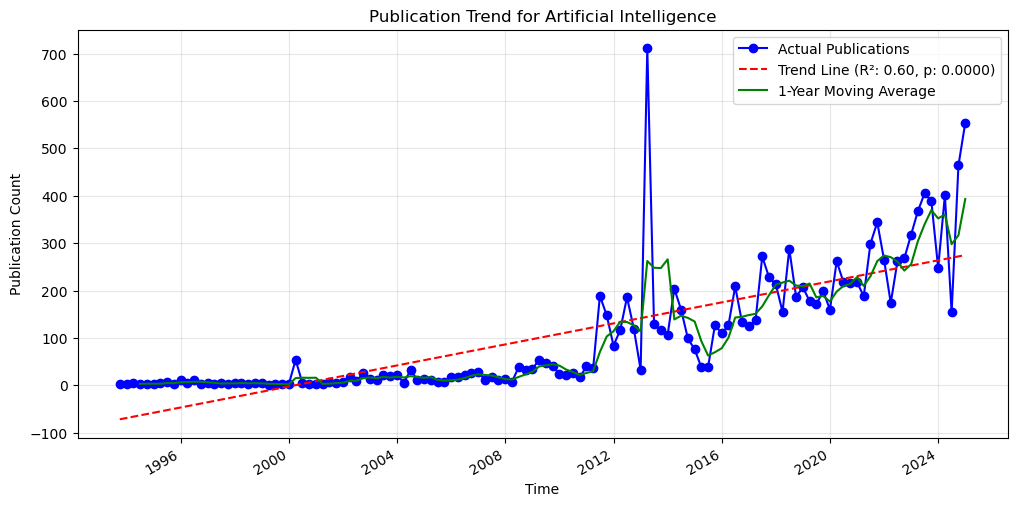

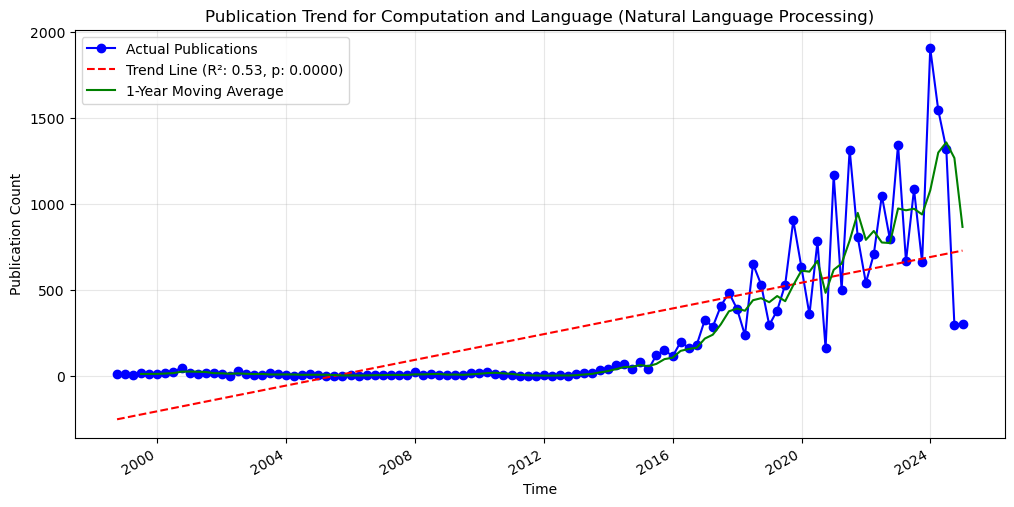

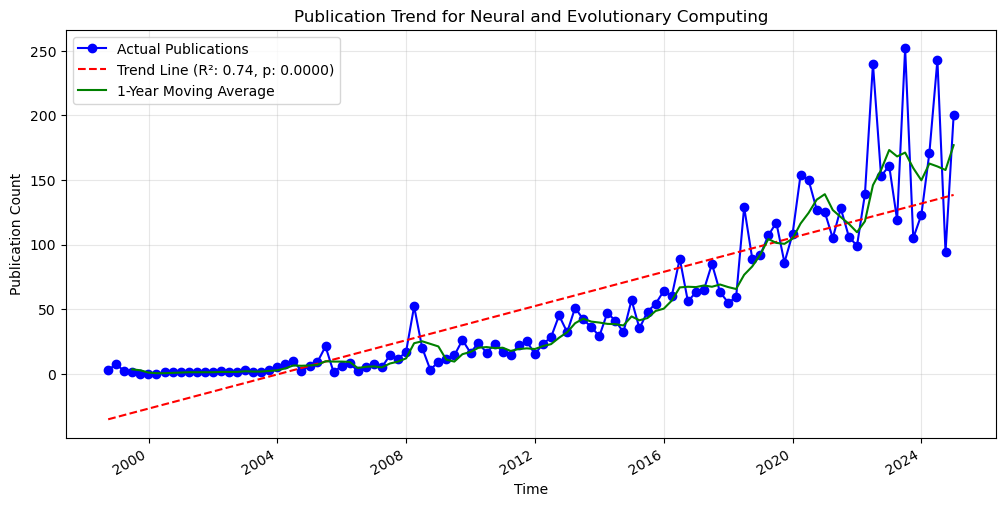

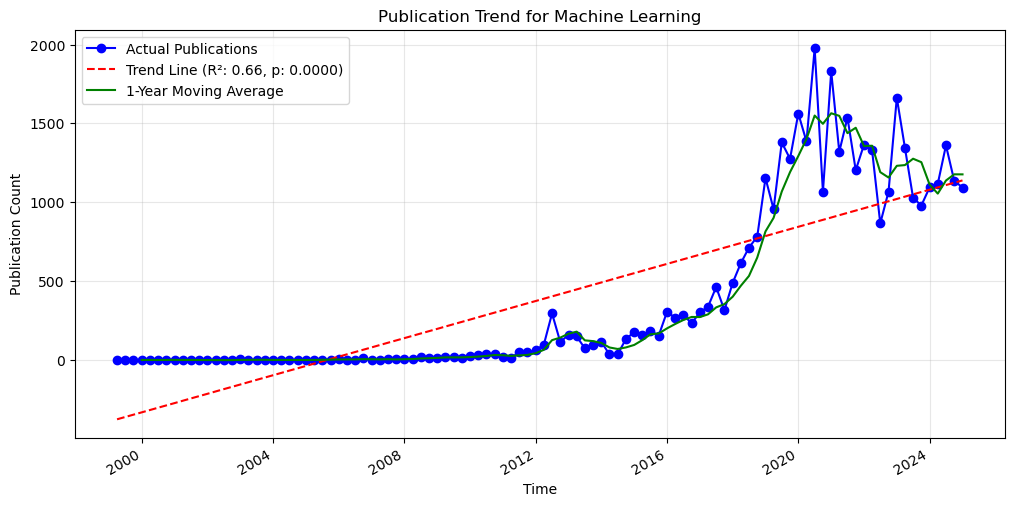

In [60]:
# Visualize individual trends for the top categories
for category in trend_analysis.head(5)['Category']:
    fig = plot_category_trend(filtered_df, category)
    plt.show()

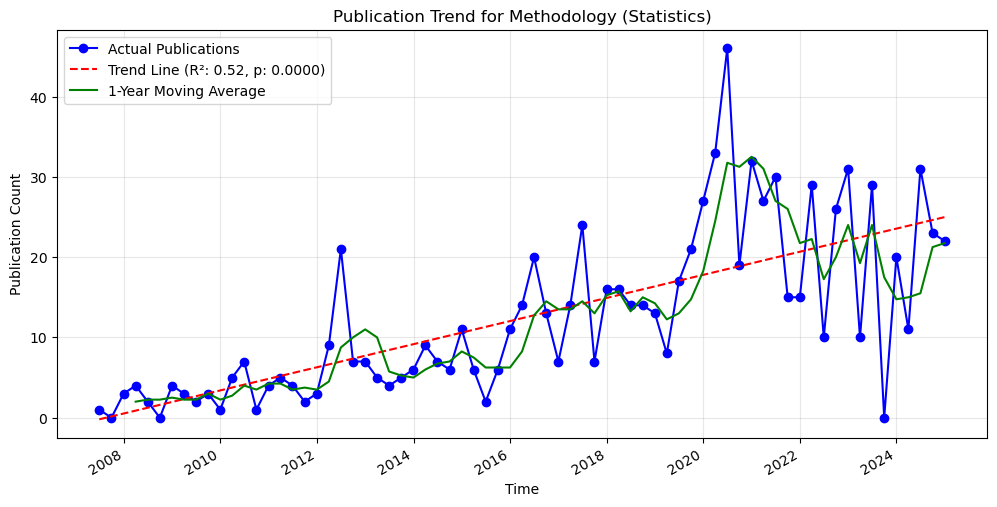

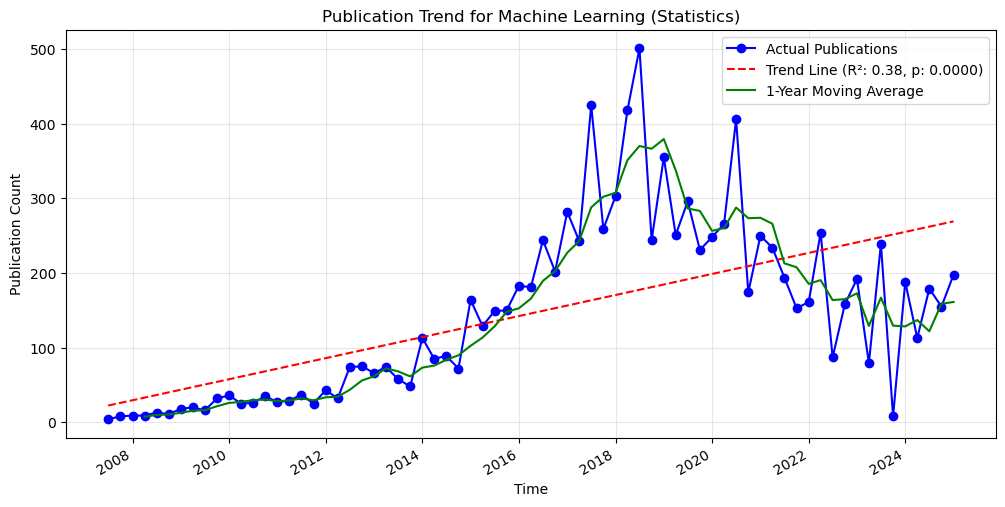

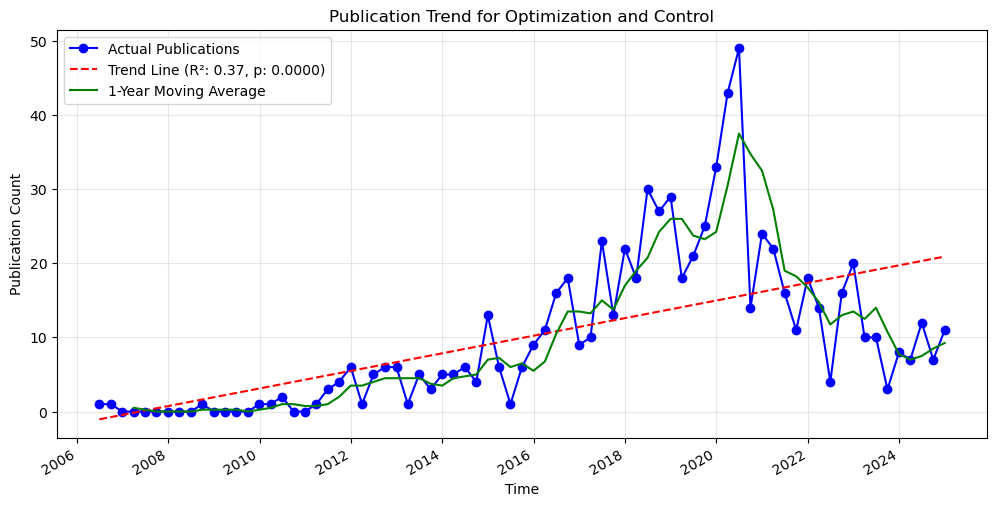

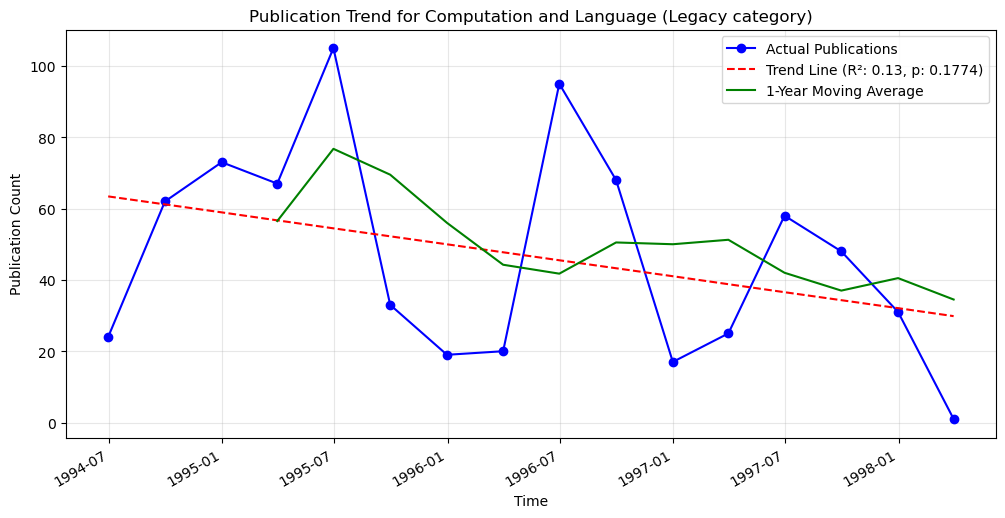

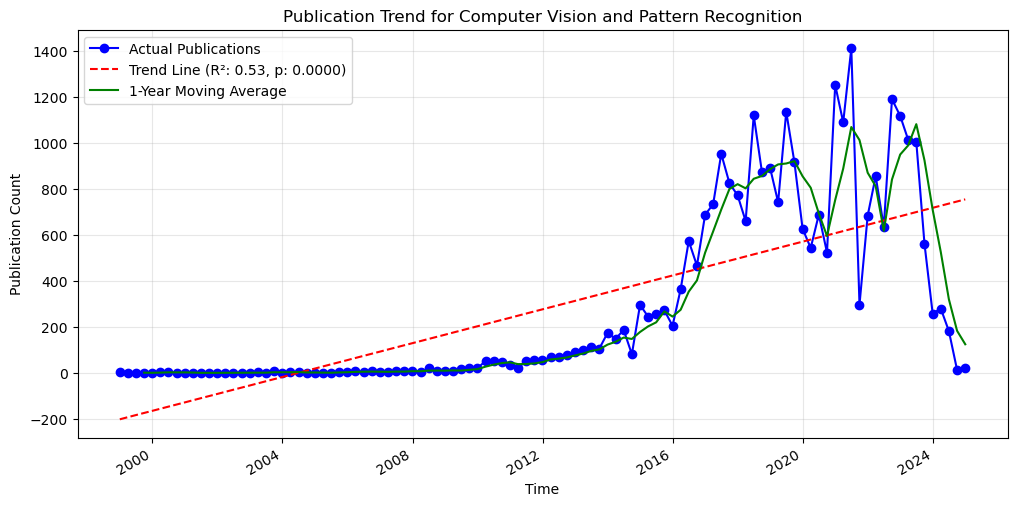

In [61]:
# Visualize individual trends for the bottom categories
for category in trend_analysis.tail(5)['Category']:
    fig = plot_category_trend(filtered_df, category)
    plt.show()

# Conclusions

There seem to be enough differences in the categories and enough noise in the data that making within category predictions is not possible. However, there is some ability to predict the growth, stability and decline of the categories in the entire dataset. 